# 1 代码训练（Project312）

## 1.1 变化主植被类型的阈值，默认超参数，分析哪个阈值的训练精度最高

# 实验工作总结

本实验基于样点数据，研究了 **Grass_man（草地比例）与 VWC 样点估算中是否需要引入树高特征（Hveg）** 的关系。通过设定不同的 Grass_man 阈值 \( X \in [0,1] \)，将数据按草地比例划分为两类区域，并分别构建模型，对比其预测误差，以探索 Hveg 特征的适用范围和最佳阈值。

---

## 实验流程

1. **数据预处理**
   - 读取样点数据表（含 VOD、LAI、Hveg、PFT、AGB、LFMC 等指标）。
   - 计算目标变量：
     ```python
     VWC_sample = (AGB * LFMCValue) / 1000
     ```
     并删除异常值 \( VWC_sample > 30 \)。
   - 随机划分训练集与验证集（比例约 2:1）。

2. **阈值划分与模型构建**
   - 设置阈值：
     ```python
     X = 0, 0.01, 0.02, … , 1.00
     ```
   - 对每个 X，将样本根据 Grass_man 阈值划分为：
     - **TH 区域**：Grass_man < X → **使用 Hveg**。
     - **No_TH 区域**：Grass_man ≥ X → **不使用 Hveg**。
   - 分别训练两套随机森林模型，并在验证集上计算 RMSE。
   - 同时计算合并后的整体 RMSE，并记录验证集样本数量。

3. **输出内容**
   - 控制台输出示例：
     ```
     X=0.01, TH=1.8859, Number_TH=112, No_TH=1.6087, Number_No_TH=1138, ALL=1.7555
     ```
   - 指标包括：
     - **RMSE_TH**：TH 区域模型误差
     - **RMSE_NoTH**：No_TH 区域模型误差
     - **RMSE_ALL**：整体误差
     - **Number_TH / Number_No_TH**：每类验证样本数
   - 绘制 RMSE vs X 曲线并保存为 `RMSE_vs_Grass_Threshold.png`。

---

## 阈值含义

| X 值 | 模型行为解释 |
|------|-------------|
| 0    | 全部样本进入 No_TH → **全部不使用 Hveg** |
| 1    | 全部样本进入 TH → **全部使用 Hveg** |
| 0 < X < 1 | 混合使用，Grass_man 高的区域不输入 Hveg |

---

## 实验目的

通过阈值分析方法：

- 探索 **树高特征 Hveg 在不同植被组成条件下的有效性边界**。
- 验证 **动态阈值分区建模是否提升 VWC 估算精度**。
- 提供模型性能与数据结构随 X 的变化趋势，为后续优化提供依据。

---

## 代码示例（划分 TH / No_TH）

```python
train_TH = X_train[X_train['Grass_man'] < X]
train_No_TH = X_train[X_train['Grass_man'] >= X]

# TH 使用 Hveg
model_TH.fit(train_TH[feature_cols], y_train_TH)

# No_TH 不使用 Hveg
features_no_Hveg = [c for c in feature_cols if c != "Hveg"]
model_No_TH.fit(train_No_TH[features_no_Hveg], y_train_No_TH)


加载数据...
预处理结束，共样本数：16013, 特征数：18, 耗时 37.3秒
X=0.00, TH=nan, Number_TH=0, No_TH=1.748558405620385, Number_No_TH=5333, ALL=1.748558405620385
X=0.01, TH=1.8859203078301545, Number_TH=2719, No_TH=1.6086754004675854, Number_No_TH=2614, ALL=1.7555067007354763
X=0.02, TH=1.8591260444253757, Number_TH=3302, No_TH=1.5285925169460297, Number_No_TH=2031, ALL=1.7406626498610922
X=0.03, TH=1.8438742946131272, Number_TH=3551, No_TH=1.5129720088591754, Number_No_TH=1782, ALL=1.7403181139281778
X=0.04, TH=1.790026132862274, Number_TH=3968, No_TH=1.5085671266032692, Number_No_TH=1365, ALL=1.7223709015775135
X=0.05, TH=1.8212518172356973, Number_TH=4201, No_TH=1.3422200942358733, Number_No_TH=1132, ALL=1.730691684274461
X=0.06, TH=1.8094529540098743, Number_TH=4377, No_TH=1.2931149203963017, Number_No_TH=956, ALL=1.7282789826040676
X=0.07, TH=1.7948406654938651, Number_TH=4479, No_TH=1.3086186661749506, Number_No_TH=854, ALL=1.726213792852077
X=0.08, TH=1.7785765317109794, Number_TH=4509, No_TH=1.2832254

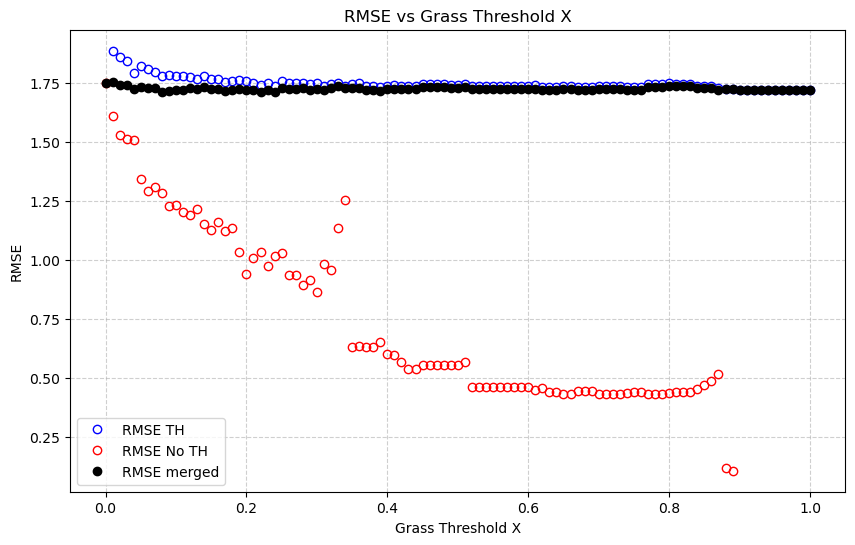

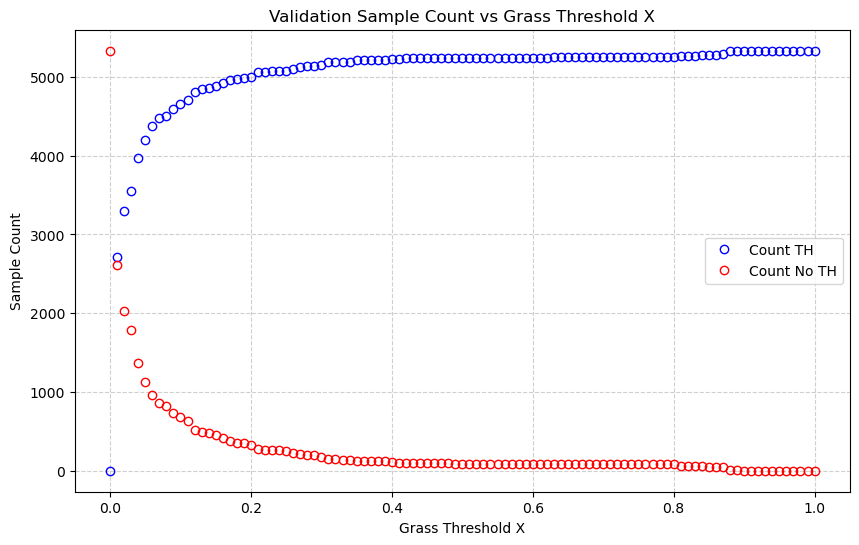

In [4]:
import pandas as pd
import numpy as np
import time
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# 固定随机种子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 文件路径
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
SAVE_DIR = r"G:\data\VWC\VWCMap\CTVWC"


def load_and_preprocess():
    """保持与原代码相同的预处理流程"""
    print("加载数据...")
    start = time.time()

    vod_columns = [
        'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
        'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
        'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
    ]

    pft_columns = [
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]

    required_columns = ['AGB', 'LFMCValue', 'SamplingDate', 'LAI', 'Hveg'] + vod_columns + pft_columns
    df = pd.read_excel(DATA_FILE_PATH, usecols=required_columns)

    if df.isnull().any().any():
        df = df.dropna()

    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]

    feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns
    X = df[feature_columns]
    y = df['VWC_sample']

    print(f"预处理结束，共样本数：{len(X)}, 特征数：{len(feature_columns)}, 耗时 {time.time()-start:.1f}秒")
    return df, X, y, feature_columns


def evaluate_threshold_model(X_train, X_val, y_train, y_val, feature_cols, X):
    """根据阈值X划分并训练随机森林模型，返回TH、NoTH和合并RMSE"""

    train_TH = X_train[X_train['Grass_man'] < X]
    train_No_TH = X_train[X_train['Grass_man'] >= X]

    y_train_TH = y_train.loc[train_TH.index]
    y_train_No_TH = y_train.loc[train_No_TH.index]

    val_TH = X_val[X_val['Grass_man'] < X]
    val_No_TH = X_val[X_val['Grass_man'] >= X]

    y_val_TH = y_val.loc[val_TH.index]
    y_val_No_TH = y_val.loc[val_No_TH.index]

    rmse_th = rmse_noth = rmse_all = np.nan
    pred_all, true_all = [], []

    # 训练TH模型（包含Hveg）
    if len(train_TH) > 0:
        model_TH = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
        model_TH.fit(train_TH[feature_cols], y_train_TH)

        if len(val_TH) > 0:
            y_pred_TH = model_TH.predict(val_TH[feature_cols])
            rmse_th = np.sqrt(mean_squared_error(y_val_TH, y_pred_TH))
            pred_all.extend(y_pred_TH)
            true_all.extend(y_val_TH.values)

    # No_TH（删掉Hveg）
    features_without_Hveg = [c for c in feature_cols if c != "Hveg"]
    if len(train_No_TH) > 0:
        model_No_TH = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
        model_No_TH.fit(train_No_TH[features_without_Hveg], y_train_No_TH)

        if len(val_No_TH) > 0:
            y_pred_No_TH = model_No_TH.predict(val_No_TH[features_without_Hveg])
            rmse_noth = np.sqrt(mean_squared_error(y_val_No_TH, y_pred_No_TH))
            pred_all.extend(y_pred_No_TH)
            true_all.extend(y_val_No_TH.values)

    if len(pred_all) > 0:
        rmse_all = np.sqrt(mean_squared_error(true_all, pred_all))

    return rmse_th, rmse_noth, rmse_all


def run_loop():
    """主循环 X = 0~1 step 0.01"""
    df, X, y, feature_cols = load_and_preprocess()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.333,
                                                      random_state=SEED, shuffle=True)

    xs = np.arange(0, 1.01, 0.01)
    rmse_th_list, rmse_noth_list, rmse_all_list = [], [], []

    for x in xs:
        rms1, rms2, rms3 = evaluate_threshold_model(X_train, X_val, y_train, y_val, feature_cols, x)

        # 验证集数量
        val_TH = X_val[X_val['Grass_man'] < x]
        val_No_TH = X_val[X_val['Grass_man'] >= x]

        num_th = len(val_TH)
        num_noth = len(val_No_TH)

        rmse_th_list.append(rms1)
        rmse_noth_list.append(rms2)
        rmse_all_list.append(rms3)

        print(f"X={x:.2f}, TH={rms1}, Number_TH={num_th}, "
            f"No_TH={rms2}, Number_No_TH={num_noth}, ALL={rms3}")

    # 绘制RMSE图
    os.makedirs(SAVE_DIR, exist_ok=True)
    plt.figure(figsize=(10, 6))
    plt.plot(xs, rmse_th_list, 'bo', markerfacecolor='none', label="RMSE TH")
    plt.plot(xs, rmse_noth_list, 'ro', markerfacecolor='none', label="RMSE No TH")
    plt.plot(xs, rmse_all_list, 'ko', label="RMSE merged")

    plt.xlabel("Grass Threshold X")
    plt.ylabel("RMSE")
    plt.title("RMSE vs Grass Threshold X")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    save_path = os.path.join(SAVE_DIR, "RMSE_vs_Grass_Threshold.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\n图像已保存至: {save_path}")
    
    # 绘制数量图（单独保存）
    plt.figure(figsize=(10, 6))
    plt.plot(xs, [len(X_val[X_val['Grass_man'] < x]) for x in xs],
             'bo', markerfacecolor='none', label="Count TH")
    plt.plot(xs, [len(X_val[X_val['Grass_man'] >= x]) for x in xs],
             'ro', markerfacecolor='none', label="Count No TH")

    plt.xlabel("Grass Threshold X")
    plt.ylabel("Sample Count")
    plt.title("Validation Sample Count vs Grass Threshold X")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    save_path2 = os.path.join(SAVE_DIR, "Count_vs_Grass_Threshold.png")
    plt.savefig(save_path2, dpi=300, bbox_inches="tight")
    print(f"数量图已保存至: {save_path2}")

if __name__ == "__main__":
    run_loop()
    print("\n全部运行结束！")


## 1.2 使用阈值X训练模型(X如何选取?)，保存至 G:\data\VWC\VWCMap\CTVWC

### 1.2.1 X=50%的情况，保存模型

In [5]:
import pandas as pd
import numpy as np
import time
import random
import os
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# 固定随机种子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 路径
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
SAVE_DIR = r"G:\data\VWC\VWCMap\CTVWC"
os.makedirs(SAVE_DIR, exist_ok=True)


def load_and_preprocess():
    """保持与你已有代码完全一致的预处理流程"""
    print("加载数据...")
    start = time.time()

    vod_columns = [
        'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
        'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
        'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
    ]

    pft_columns = [
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]

    required_columns = ['AGB', 'LFMCValue', 'SamplingDate', 'LAI', 'Hveg'] + vod_columns + pft_columns

    df = pd.read_excel(DATA_FILE_PATH, usecols=required_columns)

    # drop na
    df = df.dropna()

    # VWC 样本
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]

    # 特征
    feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns

    X = df[feature_columns]
    y = df['VWC_sample']

    print(f"预处理完成，共样本数 {len(X)}, 特征数 {len(feature_columns)}, 耗时 {time.time()-start:.1f} 秒")
    return df, X, y, feature_columns



def train_and_save_models(X, y, feature_cols, X_threshold=0.5):
    """训练两个模型并保存文件"""

    # 数据集划分
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.333, random_state=SEED, shuffle=True
    )

    # 按阈值划分
    train_TH = X_train[X_train["Grass_man"] < X_threshold]
    train_NoTH = X_train[X_train["Grass_man"] >= X_threshold]

    y_train_TH = y_train.loc[train_TH.index]
    y_train_NoTH = y_train.loc[train_NoTH.index]

    print(f"\n阈值 X = {X_threshold}")
    print(f"TH 训练样本: {len(train_TH)}, No_TH 训练样本: {len(train_NoTH)}")

    # ------- 训练 TH 模型（包含 Hveg） -------
    model_TH = None
    rmse_th = np.nan

    if len(train_TH) > 0:
        model_TH = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
        model_TH.fit(train_TH[feature_cols], y_train_TH)
        print("TH 模型训练完毕")

        # 验证集（同样条件）
        val_TH = X_val[X_val["Grass_man"] < X_threshold]
        y_val_TH = y_val.loc[val_TH.index]
        if len(val_TH) > 0:
            pred_TH = model_TH.predict(val_TH[feature_cols])
            rmse_th = np.sqrt(mean_squared_error(y_val_TH, pred_TH))
            print(f"TH 验证 RMSE = {rmse_th:.4f}")

        # 保存模型
        th_path = os.path.join(SAVE_DIR, "RFRmodel_50_TH.pkl")
        pickle.dump(model_TH, open(th_path, "wb"))
        print(f"TH 模型已保存: {th_path}")

    # ------- 训练 No_TH 模型（不含 Hveg） -------
    model_NoTH = None
    rmse_noth = np.nan
    features_without_Hveg = [c for c in feature_cols if c != "Hveg"]

    if len(train_NoTH) > 0:
        model_NoTH = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
        model_NoTH.fit(train_NoTH[features_without_Hveg], y_train_NoTH)
        print("No_TH 模型训练完毕")

        # 验证集
        val_NoTH = X_val[X_val["Grass_man"] >= X_threshold]
        y_val_NoTH = y_val.loc[val_NoTH.index]
        if len(val_NoTH) > 0:
            pred_NoTH = model_NoTH.predict(val_NoTH[features_without_Hveg])
            rmse_noth = np.sqrt(mean_squared_error(y_val_NoTH, pred_NoTH))
            print(f"No_TH 验证 RMSE = {rmse_noth:.4f}")

        # 保存模型
        noth_path = os.path.join(SAVE_DIR, "RFRmodel_50_NoTH.pkl")
        pickle.dump(model_NoTH, open(noth_path, "wb"))
        print(f"No_TH 模型已保存: {noth_path}")

    print("\n全部模型训练与保存完成！")
    return rmse_th, rmse_noth


# ------------------------------------------------
# 主程序
# ------------------------------------------------
if __name__ == "__main__":
    df, X, y, feature_cols = load_and_preprocess()
    train_and_save_models(X, y, feature_cols, X_threshold=0.5)

    print("\n程序运行完成！")


加载数据...
预处理完成，共样本数 16013, 特征数 18, 耗时 38.8 秒

阈值 X = 0.5
TH 训练样本: 10483, No_TH 训练样本: 197
TH 模型训练完毕
TH 验证 RMSE = 1.7427
TH 模型已保存: G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_TH.pkl
No_TH 模型训练完毕
No_TH 验证 RMSE = 0.5567
No_TH 模型已保存: G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_NoTH.pkl

全部模型训练与保存完成！

程序运行完成！


### 1.2.2 使用该模型生产逐日VWC数据

方法：两个模型同时生成一版，然后使用Grass的阈值，将两个模型生成的结果进行同步掩膜（NoTH的把grass＜50%的像元设置为NaN，TH把grass≥50%的像元设置为NaN）。然后进行相加，只有两版都是NaN的情况下，最终合成的结果才为NaN。

In [3]:
# run_all_vwc.py
# 先生成两个模型2015年的结果
# 用于同时调用 VWC + Hveg (TH) 和 VWC 无 Hveg (NoTH) 版本的脚本

import sys
import os
from datetime import datetime

# ============================== 路径设置 & 模块导入 ==============================

# 假设您的项目结构包含 'function' 目录
sys.path.append("./function")

try:
    # 导入 VWC + Hveg (TH) 的并行版本
    from vwc_generator import run_vwc_generation as run_vwc_hveg 
    
    # 导入 VWC 无 Hveg (NoTH) 的同步版本
    from vwc_generator_noth import run_vwc_generation as run_vwc_no_hveg 
    
except ImportError as e:
    print(f"导入失败。请检查文件是否存在且路径设置正确。错误信息: {e}")
    # 终止执行
    sys.exit(1)

# ============================== 基础配置 (2015 年) ==============================

# 时间配置 
START_DATE_STR = '2002-06-01'
END_DATE_STR = '2020-12-31' 

# 运行参数
OVERWRITE_EXISTING = True
MAX_WORKERS = 4 # 仅用于 run_vwc_hveg (并行版本)

# 数据基础路径（请根据您的实际环境修改）
VOD_PATH = r"G:\data\VOD\mat\kuxcVOD\ASC"
LAI_PATH = r"G:\data\GLASS LAI\mat\0.1Deg\Dataset"
PFT_PATH = r"G:\data\ESACCI PFT\Resample\Data"

# ============================== 任务 1: VWC + Hveg (TH) 配置 ==============================

OUTPUT_TH = r"G:\data\VWC\VWCMap\CTVWC\Daily\TH"
MODEL_TH = r'G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_TH.pkl' # 假设模型针对 2015 年

PATH_CONFIG_HVEG = {
    'vod_base_path': VOD_PATH,
    'lai_base_path': LAI_PATH,
    'pft_base_path': PFT_PATH,
    'hveg_path': r'G:\data\CanopyHeight\CH.mat', # 需要 Hveg 路径
    'output_path': OUTPUT_TH,
    'model_path': MODEL_TH
}

# 确保输出目录存在
os.makedirs(OUTPUT_TH, exist_ok=True)


# ============================== 任务 2: VWC 无 Hveg (NoTH) 配置 ==============================

OUTPUT_NOTH = r"G:\data\VWC\VWCMap\CTVWC\Daily\NoTH"
MODEL_NOTH = r'G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_NoTH.pkl' # 假设模型针对 2015 年

PATH_CONFIG_NOTH = {
    'vod_base_path': VOD_PATH,
    'lai_base_path': LAI_PATH,
    'pft_base_path': PFT_PATH,
    # 'hveg_path' 必须移除
    'output_path': OUTPUT_NOTH,
    'model_path': MODEL_NOTH
}

# 确保输出目录存在
os.makedirs(OUTPUT_NOTH, exist_ok=True)


# ============================== 执行主函数 ==============================

def main():
    
    # ------------------
    # 任务 1: VWC + Hveg (TH) - 并行
    # ------------------
    print("\n\n#####################################################")
    print(f">>> 任务 1/2: VWC + Hveg (TH) 模型 | 输出: {OUTPUT_TH}")
    print("#####################################################")
    
    if not os.path.exists(PATH_CONFIG_HVEG['model_path']):
        print(f"⚠️ 警告：TH 模型文件未找到: {PATH_CONFIG_HVEG['model_path']}，跳过此任务。")
    else:
        completed_hveg, failed_hveg = run_vwc_hveg(
            start_date_str=START_DATE_STR,
            end_date_str=END_DATE_STR,
            overwrite=OVERWRITE_EXISTING,
            max_workers=MAX_WORKERS,
            **PATH_CONFIG_HVEG
        )
        print(f"\n[总结 1/2] VWC + Hveg (TH) 结果: 成功 {completed_hveg} 天, 失败 {failed_hveg} 天")


    # ------------------
    # 任务 2: VWC 无 Hveg (NoTH) - 同步
    # ------------------
    print("\n\n#####################################################")
    print(f">>> 任务 2/2: VWC 无 Hveg (NoTH) 模型 | 输出: {OUTPUT_NOTH}")
    print("#####################################################")

    if not os.path.exists(PATH_CONFIG_NOTH['model_path']):
        print(f"⚠️ 警告：NoTH 模型文件未找到: {PATH_CONFIG_NOTH['model_path']}，跳过此任务。")
    else:
        # run_vwc_no_hveg 是同步版本，无需 max_workers 参数
        completed_noth, failed_noth = run_vwc_no_hveg(
            start_date_str=START_DATE_STR,
            end_date_str=END_DATE_STR,
            overwrite=OVERWRITE_EXISTING,
            **PATH_CONFIG_NOTH 
        )
        print(f"\n[总结 2/2] VWC 无 Hveg (NoTH) 结果: 成功 {completed_noth} 天, 失败 {failed_noth} 天")


if __name__ == "__main__":
    main()

2025-11-28 17:24:48,530 - INFO - 初始化 VWCGenerator...




#####################################################
>>> 任务 1/2: VWC + Hveg (TH) 模型 | 输出: G:\data\VWC\VWCMap\CTVWC\Daily\TH
#####################################################


2025-11-28 17:24:49,543 - INFO - 成功加载模型: G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_TH.pkl
2025-11-28 17:24:49,544 - INFO - 模型期望的特征顺序: VOD_Ku_Hpol_Asc, VOD_Ku_Vpol_Asc, VOD_X_Hpol_Asc, VOD_X_Vpol_Asc, VOD_C_Hpol_Asc, VOD_C_Vpol_Asc, LAI, Hveg, Grass_man, Grass_nat, Shrub_bd, Shrub_be, Shrub_nd, Shrub_ne, Tree_bd, Tree_be, Tree_nd, Tree_ne
2025-11-28 17:24:49,544 - INFO - 加载Hveg数据: G:\data\CanopyHeight\CH.mat
2025-11-28 17:24:49,771 - INFO - 成功加载Hveg数据: Hveg
2025-11-28 17:24:49,771 - INFO - Hveg数据加载完成: (1800, 3600)
2025-11-28 17:24:49,774 - INFO - 陆地掩膜创建完成: 有效点=5040000
2025-11-28 17:24:49,778 - INFO - 开始并行处理6789天数据，最大线程数: 4
2025-11-28 17:24:49,780 - INFO - 处理日期: 2002-06-01


开始处理: 2002-06-01 到 2020-12-31


2025-11-28 17:24:49,844 - INFO - 处理日期: 2002-06-02
2025-11-28 17:24:49,844 - INFO - 处理日期: 2002-06-04
2025-11-28 17:24:49,971 - INFO - 处理日期: 2002-06-03
生成VWC影像:   0%|          | 0/6789 [00:00<?, ?it/s]2025-11-28 17:24:56,778 - INFO - 有效数据点数量: 222189
2025-11-28 17:24:56,996 - INFO - 有效数据点数量: 847483
2025-11-28 17:24:57,082 - INFO - 有效数据点数量: 950090
2025-11-28 17:24:57,894 - INFO - 有效数据点数量: 907268
2025-11-28 17:24:59,982 - INFO - 预测值统计: min=0.0099, max=24.8354, mean=5.1064

2025-11-28 17:25:00,194 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Daily\TH\VWC-20020601.tif
生成VWC影像:   0%|          | 1/6789 [00:10<19:26:19, 10.31s/it]2025-11-28 17:25:00,312 - INFO - 处理日期: 2002-06-05

2025-11-28 17:25:02,172 - INFO - 预测值统计: min=0.0053, max=26.7787, mean=3.9090
2025-11-28 17:25:02,386 - INFO - 有效数据点数量: 948068
2025-11-28 17:25:02,416 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Daily\TH\VWC-20020603.tif
生成VWC影像:   0%|          | 2/6789 [00:12<10:26:16,  5.54s/it]2025-11-28 17:25:02,496 - INFO - 处理日

VWC影像生成完成: 成功 6449 天, 失败 340 天

[总结 1/2] VWC + Hveg (TH) 结果: 成功 6449 天, 失败 340 天


#####################################################
>>> 任务 2/2: VWC 无 Hveg (NoTH) 模型 | 输出: G:\data\VWC\VWCMap\CTVWC\Daily\NoTH
#####################################################


2025-11-28 19:29:39,099 - INFO - 成功加载模型: G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_NoTH.pkl
2025-11-28 19:29:39,100 - INFO - 模型期望的特征顺序: VOD_Ku_Hpol_Asc, VOD_Ku_Vpol_Asc, VOD_X_Hpol_Asc, VOD_X_Vpol_Asc, VOD_C_Hpol_Asc, VOD_C_Vpol_Asc, LAI, Grass_man, Grass_nat, Shrub_bd, Shrub_be, Shrub_nd, Shrub_ne, Tree_bd, Tree_be, Tree_nd, Tree_ne
2025-11-28 19:29:39,104 - INFO - 陆地掩膜创建完成: 有效点=5040000
2025-11-28 19:29:39,107 - INFO - 开始同步处理6789天数据


开始处理: 2002-06-01 到 2020-12-31


生成VWC影像:   0%|          | 0/6789 [00:00<?, ?it/s]2025-11-28 19:29:39,109 - INFO - 处理日期: 2002-06-01
2025-11-28 19:29:40,603 - INFO - 有效数据点数量: 222189
2025-11-28 19:29:41,033 - INFO - 预测值统计: min=0.0601, max=4.2874, mean=2.3554
2025-11-28 19:29:41,167 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Daily\NoTH\VWC-20020601.tif
生成VWC影像:   0%|          | 1/6789 [00:02<3:54:56,  2.08s/it]2025-11-28 19:29:41,187 - INFO - 处理日期: 2002-06-02
2025-11-28 19:29:41,816 - INFO - 有效数据点数量: 950090
2025-11-28 19:29:42,992 - INFO - 预测值统计: min=0.0462, max=4.2608, mean=2.4094
2025-11-28 19:29:43,102 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Daily\NoTH\VWC-20020602.tif
生成VWC影像:   0%|          | 2/6789 [00:04<3:45:48,  2.00s/it]2025-11-28 19:29:43,127 - INFO - 处理日期: 2002-06-03
2025-11-28 19:29:43,761 - INFO - 有效数据点数量: 847483
2025-11-28 19:29:44,852 - INFO - 预测值统计: min=0.0516, max=4.2129, mean=2.3706
2025-11-28 19:29:44,955 - INFO - 成功创建GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Daily\NoTH\VWC-20020603.tif
生成VWC影像:   

VWC影像生成完成: 成功 6449 天, 失败 340 天

[总结 2/2] VWC 无 Hveg (NoTH) 结果: 成功 6449 天, 失败 340 天


In [4]:
# 合并为最终产品

import os
import sys
import glob
import numpy as np
import h5py
import rasterio
from datetime import datetime, timedelta

# --- 确保安装了依赖库 ---
# pip install h5py rasterio numpy

# ============================== 配置区域 (请根据实际情况修改) ==============================

# 时间配置
START_DATE_STR = '2002-06-01'
END_DATE_STR = '2020-12-31' 

# 结果路径配置
BASE_OUTPUT_DIR = r"G:\data\VWC\VWCMap\CTVWC\Daily"
OUTPUT_TH = os.path.join(BASE_OUTPUT_DIR, "TH")
OUTPUT_NOTH = os.path.join(BASE_OUTPUT_DIR, "NoTH")
OUTPUT_MERGED = BASE_OUTPUT_DIR # 合并后的文件直接放在 Daily 目录下

# PFT 辅助文件配置
PFT_PATH = r"G:\data\ESACCI PFT\Resample\Data"

# VWC 影像的预期形状（从调试结果中确定）
EXPECTED_VWC_SHAPE = (1800, 3600) 

# ============================== 函数定义 ==============================

def load_pft_mask(pft_mat_file):
    """
    读取 2015.mat 中的 PFT 数据，计算 Grassman + Grassnat 阈值掩模，并强制转置以匹配 VWC 影像。
    """
    print(f"\n加载 PFT 文件用于创建掩模: {pft_mat_file}")
    
    if not os.path.exists(pft_mat_file):
        raise FileNotFoundError(f"PFT 文件未找到: {pft_mat_file}")
        
    try:
        with h5py.File(pft_mat_file, 'r') as f:
            grassman = f['grassman'][:] 
            grassnat = f['grassnat'][:]
            
            pft_current_shape = grassman.shape
            
            # --- 核心修复：强制转置以匹配 VWC 影像的 (1800, 3600) 形状 ---
            # 根据您的调试结果，PFT 原始形状是 (3600, 1800)，需要转置。
            if pft_current_shape == EXPECTED_VWC_SHAPE:
                # 理论上不应该发生，但作为安全检查
                print(f"PFT 原始形状 {pft_current_shape} 已匹配。")
            elif pft_current_shape == EXPECTED_VWC_SHAPE[::-1]: # 检查是否是 (3600, 1800)
                grassman = grassman.T
                grassnat = grassnat.T
                print(f"PFT 数据已转置: {pft_current_shape} -> {grassman.shape}")
            else:
                # 如果形状既不是 (1800, 3600) 也不是 (3600, 1800)，则抛出错误
                raise ValueError(
                    f"PFT 原始形状 {pft_current_shape} 与预期的 VWC 形状 {EXPECTED_VWC_SHAPE} 不匹配。"
                )
                
            # 计算总草地占比：(grassman + grassnat) / 100
            total_grass_fraction = (grassman + grassnat) / 100.0
            
            # 创建掩模：True 表示使用 NoTH (总草地占比 >= 0.5)
            mask = (total_grass_fraction >= 0.5)
            print(f"PFT 掩模创建完毕。高草地占比 (>= 0.5) 像元数: {np.sum(mask)}")
            return mask
            
    except Exception as e:
        print(f"读取或处理 PFT 文件时发生错误: {e}")
        sys.exit(1)


def merge_vwc_products(start_date_str, end_date_str, output_th_dir, output_noth_dir, output_merged_dir, pft_path):
    """
    根据 PFT 阈值掩模，合并 TH 和 NoTH 文件夹中的每日 VWC 文件。
    动态加载 PFT 文件。
    """
    print("\n--- 启动 VWC 产品合并 ---")
    
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    current_date = start_date
    processed_count = 0
    
    # 动态 PFT 加载所需变量
    current_year = None
    pft_mask = None
    
    while current_date <= end_date:
        # 检查年份是否变化，如果变化，则重新加载 PFT 掩模
        date_year = current_date.year
        
        if date_year != current_year:
            print(f"\n>>>> 切换到年份 {date_year}，重新加载 PFT 掩模...")
            
            # 1. 构造新的 PFT 文件路径
            pft_mat_file = os.path.join(pft_path, f'{date_year}.mat') 
            
            # 2. 尝试加载 PFT 掩模，如果文件不存在则跳过该年剩余日期
            try:
                pft_mask = load_pft_mask(pft_mat_file)
                current_year = date_year # 成功加载，更新当前年份
            except FileNotFoundError as e:
                print(f"警告：年份 {date_year} 的 PFT 文件 {pft_mat_file} 不存在。跳过该年的所有日期。")
                current_date = datetime(date_year + 1, 1, 1) # 跳到下一年
                continue # 进入下一个 while 循环
            except Exception as e:
                print(f"严重错误：加载 PFT 掩模失败。程序终止。错误: {e}")
                sys.exit(1)
        
        # ----------------------------------------------------
        # 每日数据处理逻辑（保持不变）
        # ----------------------------------------------------
        date_str = current_date.strftime('%Y%m%d')
        filename = f"VWC-{date_str}.tif" 
        
        path_th = os.path.join(output_th_dir, filename)
        path_noth = os.path.join(output_noth_dir, filename)
        path_out = os.path.join(output_merged_dir, filename)

        if not os.path.exists(path_th) or not os.path.exists(path_noth):
            current_date += timedelta(days=1)
            continue
            
        try:
            # ... (读取 TH 和 NoTH 文件，合并数据的逻辑保持不变)
            with rasterio.open(path_th) as src_th:
                th_data = src_th.read(1)
                profile = src_th.profile 

            with rasterio.open(path_noth) as src_noth:
                noth_data = src_noth.read(1)
                
            if th_data.shape != pft_mask.shape:
                raise ValueError(
                    f"VWC 影像形状 {th_data.shape} 与 PFT 掩模形状 {pft_mask.shape} 不匹配！"
                )

            merged_data = np.empty_like(th_data, dtype=th_data.dtype) 
            merged_data[pft_mask] = noth_data[pft_mask]
            merged_data[~pft_mask] = th_data[~pft_mask]

            NODATA_VALUE = -9999
            merged_data[np.isnan(merged_data)] = NODATA_VALUE 
            
            profile.update(dtype=merged_data.dtype, nodata=NODATA_VALUE) 
            
            with rasterio.open(path_out, 'w', **profile) as dst:
                dst.write(merged_data, 1)

            processed_count += 1
            
        except Exception as e:
            print(f"❌ 处理文件 {filename} 时失败: {e}")
            
        current_date += timedelta(days=1)
        
    print(f"\n--- VWC 产品合并完成。总计处理文件数: {processed_count} ---")


# ============================== 主程序运行 ==============================

if __name__ == "__main__":
    
    print("\n\n#####################################################")
    print(">>> 独立任务: VWC 产品合并 (TH/NoTH)")
    print("#####################################################")
    
    try:
        # 1. 确保合并输出目录存在
        os.makedirs(OUTPUT_MERGED, exist_ok=True)
        
        # 2. 执行合并 (将 PFT_PATH 作为参数传入，而不是已加载的掩模)
        merge_vwc_products(
            START_DATE_STR, END_DATE_STR, 
            OUTPUT_TH, OUTPUT_NOTH, OUTPUT_MERGED, 
            PFT_PATH # <-- 传入 PFT 文件的基目录
        )
    except Exception as e:
        print(f"\n❗ 合并过程中发生未知错误: {e}")



#####################################################
>>> 独立任务: VWC 产品合并 (TH/NoTH)
#####################################################

--- 启动 VWC 产品合并 ---

>>>> 切换到年份 2002，重新加载 PFT 掩模...

加载 PFT 文件用于创建掩模: G:\data\ESACCI PFT\Resample\Data\2002.mat
PFT 数据已转置: (3600, 1800) -> (1800, 3600)
PFT 掩模创建完毕。高草地占比 (>= 0.5) 像元数: 719818

>>>> 切换到年份 2003，重新加载 PFT 掩模...

加载 PFT 文件用于创建掩模: G:\data\ESACCI PFT\Resample\Data\2003.mat
PFT 数据已转置: (3600, 1800) -> (1800, 3600)
PFT 掩模创建完毕。高草地占比 (>= 0.5) 像元数: 719990

>>>> 切换到年份 2004，重新加载 PFT 掩模...

加载 PFT 文件用于创建掩模: G:\data\ESACCI PFT\Resample\Data\2004.mat
PFT 数据已转置: (3600, 1800) -> (1800, 3600)
PFT 掩模创建完毕。高草地占比 (>= 0.5) 像元数: 721376

>>>> 切换到年份 2005，重新加载 PFT 掩模...

加载 PFT 文件用于创建掩模: G:\data\ESACCI PFT\Resample\Data\2005.mat
PFT 数据已转置: (3600, 1800) -> (1800, 3600)
PFT 掩模创建完毕。高草地占比 (>= 0.5) 像元数: 721546

>>>> 切换到年份 2006，重新加载 PFT 掩模...

加载 PFT 文件用于创建掩模: G:\data\ESACCI PFT\Resample\Data\2006.mat
PFT 数据已转置: (3600, 1800) -> (1800, 3600)
PFT 掩模创建完毕。高草地占比 (>= 0.5) 像元

In [1]:
# 单日数据的生成（支持Hveg特征，根据Grass比例选择模型）
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import h5py
from osgeo import gdal, osr
import logging
from tqdm import tqdm
import concurrent.futures
import warnings
import sys

# 忽略警告
warnings.filterwarnings('ignore')

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 全局文件路径常量
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
VOD_BASE_PATH = r"G:\data\VOD\mat\kuxcVOD\ASC"
LAI_BASE_PATH = r"G:\data\GLASS LAI\mat\0.1Deg\Dataset"
PFT_BASE_PATH = r"G:\data\ESACCI PFT\Resample\Data"
OUTPUT_PATH = r"G:\data\VWC\VWCMap\CTVWC\Daily"  # 修改输出路径
Hveg_PATH = r'G:\data\CanopyHeight\CH.mat'  # Hveg数据路径

# 确保输出目录存在
os.makedirs(OUTPUT_PATH, exist_ok=True)

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('vwc_generation_grass_threshold.log')
    ]
)
logger = logging.getLogger()

# 加载两个模型
MODEL_TH_PATH = r'G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_TH.pkl'  # 使用树高的模型
MODEL_NOTH_PATH = r'G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_NoTH.pkl'  # 不使用树高的模型

MODEL_TH = None
MODEL_NOTH = None

try:
    if os.path.exists(MODEL_TH_PATH):
        MODEL_TH = joblib.load(MODEL_TH_PATH)
        logger.info(f"成功加载TH模型: {MODEL_TH_PATH}")
        logger.info(f"TH模型特征数: {MODEL_TH.n_features_in_}")
    else:
        logger.error(f"TH模型文件不存在: {MODEL_TH_PATH}")
        sys.exit(1)
        
    if os.path.exists(MODEL_NOTH_PATH):
        MODEL_NOTH = joblib.load(MODEL_NOTH_PATH)
        logger.info(f"成功加载NoTH模型: {MODEL_NOTH_PATH}")
        logger.info(f"NoTH模型特征数: {MODEL_NOTH.n_features_in_}")
    else:
        logger.error(f"NoTH模型文件不存在: {MODEL_NOTH_PATH}")
        sys.exit(1)
        
except Exception as e:
    logger.error(f"加载模型失败: {str(e)}")
    sys.exit(1)

# 缓存机制
LAI_MONTH_CACHE = {}  # 缓存LAI数据（按年月）
PFT_YEAR_CACHE = {}    # 缓存PFT数据（按年）

# ============================== 加载Hveg数据 ==============================
Hveg_DATA = None
try:
    logger.info(f"加载Hveg数据: {Hveg_PATH}")
    with h5py.File(Hveg_PATH, 'r') as f:
        # 尝试不同可能的变量名
        for key in ['Hveg', 'CanopyHeight', 'CH']:
            if key in f:
                Hveg_DATA = np.array(f[key][:])
                logger.info(f"成功加载Hveg数据: {key}")
                break
        else:
            logger.warning("未找到Hveg变量，尝试使用第一个数据集")
            keys = list(f.keys())
            if keys:
                Hveg_DATA = np.array(f[keys[0]][:])
                logger.warning(f"使用默认数据集 '{keys[0]}' 作为Hveg数据")
    
    # 确保数据形状正确 (1800, 3600)
    if Hveg_DATA.shape == (3600, 1800):
        Hveg_DATA = Hveg_DATA.T
    elif Hveg_DATA.shape != (1800, 3600):
        logger.error(f"不支持的Hveg数据形状: {Hveg_DATA.shape}")
        Hveg_DATA = None
    
    if Hveg_DATA is not None:
        logger.info("Hveg数据加载完成")
except Exception as e:
    logger.error(f"加载Hveg数据失败: {str(e)}")
    Hveg_DATA = None

# ============================== 辅助函数 ==============================
def create_singleband_geotiff(data, output_path, nodata=-9999.0):
    """创建单波段地理参考的TIFF文件"""
    try:
        driver = gdal.GetDriverByName('GTiff')
        rows, cols = data.shape
        
        # 创建数据集
        out_ds = driver.Create(
            output_path, 
            cols, 
            rows, 
            1, 
            gdal.GDT_Float32,
            options=['COMPRESS=LZW', 'BIGTIFF=YES']
        )
        
        # 设置地理变换
        geotransform = (-180.0, 0.1, 0.0, 90.0, 0.0, -0.1)
        out_ds.SetGeoTransform(geotransform)
        
        # 设置坐标系 (WGS84)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        out_ds.SetProjection(srs.ExportToWkt())
        
        # 写入波段数据
        band = out_ds.GetRasterBand(1)
        band.WriteArray(data)
        band.SetNoDataValue(nodata)
        band.SetDescription('VWC')
        
        # 清理
        out_ds.FlushCache()
        out_ds = None
        
        logger.info(f"成功创建GeoTIFF: {output_path}")
        return True
    except Exception as e:
        logger.error(f"创建GeoTIFF失败: {str(e)}")
        return False

def get_vod_file(date):
    """获取VOD文件路径"""
    date_str = date.strftime('%Y%m%d')
    
    # 查找VOD文件
    possible_files = [
        f'MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{date_str}_V0.nc4.mat',
        f'MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{date_str}_V0.mat',
        f'MCCA_AMSRE_010D_CCXH_VSM_VOD_Asc_{date_str}_V0.nc4.mat',
        f'MCCA_AMSRE_010D_CCXH_VSM_VOD_Asc_{date_str}.mat'
    ]
    
    for filename in possible_files:
        file_path = os.path.join(VOD_BASE_PATH, filename)
        if os.path.exists(file_path):
            return file_path
    
    logger.warning(f"未找到VOD文件: {date_str}")
    return None

def get_lai_file(year, month):
    """获取LAI文件路径"""
    month_str = str(month).zfill(2)
    
    # 尝试文件名格式
    possible_files = [
        f'{year}-{month_str}-01.tif.mat',
        f'{year}-{month_str}-01.mat',
        f'LAI_{year}{month_str}.mat',
        f'{year}_{month_str}_LAI.mat'
    ]
    
    for filename in possible_files:
        file_path = os.path.join(LAI_BASE_PATH, filename)
        if os.path.exists(file_path):
            return file_path
    
    logger.warning(f"未找到LAI文件: {year}-{month_str}")
    return None

def get_pft_file(year):
    """获取PFT文件路径"""
    # 尝试不同文件名
    possible_files = [
        f'{year}.mat',
        f'PFT_{year}.mat',
        f'ESACCI_PFT_{year}.mat',
        f'pft_{year}.mat'
    ]
    
    for filename in possible_files:
        file_path = os.path.join(PFT_BASE_PATH, filename)
        if os.path.exists(file_path):
            return file_path
    
    logger.warning(f"未找到PFT文件: {year}")
    return None

def get_month_centers(date):
    """获取用于插值的前后月中日期"""
    current_mid = date.replace(day=15)
    
    if date.day <= 15:
        prev_mid = (current_mid - timedelta(days=30)).replace(day=15)
        next_mid = current_mid
    else:
        prev_mid = current_mid
        next_mid = (current_mid + timedelta(days=30)).replace(day=15)
    return prev_mid, next_mid

def load_lai_matrix(file_path):
    """加载LAI矩阵数据"""
    if not file_path or not os.path.exists(file_path): 
        return None
    
    try:
        with h5py.File(file_path, 'r') as f:
            # 尝试不同数据集名称
            for key in ['lai', 'Layer', 'data']:
                if key in f:
                    lai_data = np.array(f[key][:])
                    break
            else:
                # 使用第一个数据集
                keys = list(f.keys())
                if keys:
                    lai_data = np.array(f[keys[0]][:])
                    logger.warning(f"使用默认数据集 '{keys[0]}' 作为LAI数据: {file_path}")
                else:
                    logger.warning(f"未找到数据集: {file_path}")
                    return None
            
            # 转置为(1800,3600)
            if lai_data.shape == (3600, 1800):
                lai_data = lai_data.T
            elif lai_data.shape != (1800, 3600):
                logger.error(f"不支持的LAI数据形状: {lai_data.shape}")
                return None
            
            return lai_data
    except Exception as e:
        logger.error(f"加载LAI文件失败: {file_path} - {str(e)}")
        return None

def load_pft_matrix(file_path):
    """加载并旋转PFT矩阵数据"""
    if not file_path or not os.path.exists(file_path): 
        return None
    
    try:
        pft_data = {}
        with h5py.File(file_path, 'r') as f:
            # 定义植被类型映射
            pft_mapping = {
                'water': ['water', 'WATER'],
                'bare': ['bare', 'bareland', 'BARE'],
                'snowice': ['snowice', 'snow', 'ice', 'SNOWICE'],
                'built': ['built', 'urban', 'BUILT'],
                'grassnat': ['grassnat', 'grass_natural', 'GRASSNAT'],
                'grassman': ['grassman', 'grass_managed', 'GRASSMAN'],
                'shrubbd': ['shrubbd', 'shrub_bd', 'SHRUBBD'],
                'shrubbe': ['shrubbe', 'shrub_be', 'SHRUBBE'],
                'shrubnd': ['shrubnd', 'shrub_nd', 'SHRUBND'],
                'shrubne': ['shrubne', 'shrub_ne', 'SHRUBNE'],
                'treebd': ['treebd', 'tree_bd', 'TREEBD'],
                'treebe': ['treebe', 'tree_be', 'TREEBE'],
                'treend': ['treend', 'tree_nd', 'TREEND'],
                'treene': ['treene', 'tree_ne', 'TREENE']
            }
            
            # 查找匹配的数据集
            matched_datasets = {}
            for target, aliases in pft_mapping.items():
                for alias in aliases:
                    if alias in f:
                        data = np.array(f[alias][:])
                        # 旋转和转置
                        if data.shape == (3600, 7200):
                            # 从0.05度到0.1度的降采样
                            data = np.rot90(data, k=-1)
                            # 平均聚合到0.1度
                            data = (data[:, ::2] + data[:, 1::2]) / 2.0
                            pft_data[target] = data.T
                        elif data.shape == (3600, 1800):
                            pft_data[target] = np.rot90(data, k=-1)
                        elif data.shape == (1800, 3600):
                            pft_data[target] = data
                        else:
                            logger.warning(f"未知PFT形状: {data.shape} for {target}")
                            pft_data[target] = np.zeros((1800, 3600))
                        matched_datasets[alias] = True
                        break
                else:
                    logger.warning(f"未找到 {target} 的PFT数据")
                    pft_data[target] = np.zeros((1800, 3600))
                
        return pft_data
    except Exception as e:
        logger.error(f"加载PFT文件失败: {file_path} - {str(e)}")
        return None

def create_land_mask(rows=1800, cols=3600):
    """创建简单的陆地掩膜"""
    # 创建纬度数组
    lats = np.linspace(90, -90, rows)
    
    # 创建陆地掩膜 (排除极地和海洋)
    land_mask = np.zeros((rows, cols), dtype=bool)
    for i in range(rows):
        if -60 <= lats[i] <= 80:  # 排除南极和北极
            land_mask[i, :] = True
    
    return land_mask

def prepare_features(vod_data, lai_data, pft_data, hveg_data, valid_mask):
    """准备特征矩阵（6VOD + LAI + Hveg + PFTs）"""
    # 获取有效索引
    valid_indices = np.where(valid_mask)
    num_valid = len(valid_indices[0])
    
    if num_valid == 0:
        logger.warning("无有效数据点")
        return None, None, None, None
    
    # 初始化特征矩阵
    features = np.zeros((num_valid, 0), dtype=np.float32)
    feature_names = []
    
    # 1. VOD特征 (6个波段) - 不再归一化
    vod_keys = [
        'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
        'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
        'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
    ]
    
    # 定义MAT文件中VOD变量的实际名称
    vod_mat_mapping = {
        'VOD_Ku_Hpol_Asc': 'ku_vod_H',
        'VOD_Ku_Vpol_Asc': 'ku_vod_V',
        'VOD_X_Hpol_Asc': 'x_vod_H',
        'VOD_X_Vpol_Asc': 'x_vod_V',
        'VOD_C_Hpol_Asc': 'c_vod_H',
        'VOD_C_Vpol_Asc': 'c_vod_V'
    }
    
    for key in vod_keys:
        # 获取MAT文件中的实际变量名
        mat_key = vod_mat_mapping.get(key)
        
        # 检查是否在VOD数据中
        if mat_key in vod_data:
            vod_val = vod_data[mat_key]   # 不再除以1.5
            features = np.column_stack((features, vod_val[valid_indices]))
            feature_names.append(key)
            logger.debug(f"成功加载VOD特征: {key} (MAT变量: {mat_key})")
        elif key in vod_data:
            # 如果使用标准名称存在
            vod_val = vod_data[key]   # 不再除以1.5
            features = np.column_stack((features, vod_val[valid_indices]))
            feature_names.append(key)
            logger.debug(f"成功加载VOD特征: {key}")
        else:
            logger.warning(f"VOD特征缺失: {key}，使用0填充")
            features = np.column_stack((features, np.zeros(num_valid)))
            feature_names.append(key)
    
    # 2. LAI特征 (不再归一化)
    feature_names.append('LAI')
    if lai_data is not None:
        lai_val = lai_data   # 不再除以6.0
        features = np.column_stack((features, lai_val[valid_indices]))
    else:
        logger.warning("LAI特征缺失，使用0填充")
        features = np.column_stack((features, np.zeros(num_valid)))
    
    # 3. Hveg特征 (不归一化)
    feature_names.append('Hveg')
    if hveg_data is not None:
        # 注意：hveg_data是全局矩阵，我们根据valid_indices提取有效点
        hveg_val = hveg_data[valid_indices]
        features = np.column_stack((features, hveg_val))
    else:
        logger.warning("Hveg特征缺失，使用0填充")
        features = np.column_stack((features, np.zeros(num_valid)))
    
    # 4. PFT特征 (归一化)
    pft_features = [
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    grass_ratio = None  # 初始化Grass比例
    
    for feature in pft_features:
        feature_names.append(feature)
        if pft_data is not None:
            # PFT特征映射
            pft_mapping = {
                'Grass_man': 'grassman',
                'Grass_nat': 'grassnat',
                'Shrub_bd': 'shrubbd',
                'Shrub_be': 'shrubbe',
                'Shrub_nd': 'shrubnd',
                'Shrub_ne': 'shrubne',
                'Tree_bd': 'treebd',
                'Tree_be': 'treebe',
                'Tree_nd': 'treend',
                'Tree_ne': 'treene'
            }
            
            pft_key = pft_mapping.get(feature)
            if pft_key and pft_key in pft_data:
                pft_val = pft_data[pft_key] / 100.0   # PFT特征归一化（除以100）
                features = np.column_stack((features, pft_val[valid_indices]))
                
                # 计算Grass比例 (Grass_man + Grass_nat)
                if pft_key == 'grassman' and grass_ratio is None:
                    grass_ratio = np.zeros((1800, 3600), dtype=np.float32)
                    grass_ratio += pft_data[pft_key] / 100.0
                elif pft_key == 'grassnat' and grass_ratio is not None:
                    grass_ratio += pft_data[pft_key] / 100.0
                    
            else:
                logger.warning(f"PFT特征缺失: {feature}，使用0填充")
                features = np.column_stack((features, np.zeros(num_valid)))
        else:
            logger.warning("PFT数据缺失，使用0填充")
            features = np.column_stack((features, np.zeros(num_valid)))
    
    logger.info(f"准备特征完成: {features.shape} 形状, 特征数: {len(feature_names)}")
    return features, feature_names, valid_indices, grass_ratio

def predict_vwc_with_grass_threshold(features, feature_names, grass_ratio, valid_mask, rows=1800, cols=3600):
    """根据Grass比例选择不同模型预测VWC"""
    if features is None:
        return None
    
    # 初始化结果数组
    vwc_array = np.full((rows, cols), -9999.0, dtype=np.float32)
    valid_indices = np.where(valid_mask)
    num_valid = len(valid_indices[0])
    
    if num_valid == 0:
        logger.warning("无有效数据点")
        return vwc_array
    
    try:
        # 根据Grass比例创建掩膜
        if grass_ratio is None:
            logger.warning("无法获取Grass比例，默认使用TH模型")
            grass_mask = np.zeros((rows, cols), dtype=bool)  # 全部使用TH模型
        else:
            # Grass比例 > 0.5 的区域使用NoTH模型，否则使用TH模型
            grass_mask = grass_ratio > 0.5
        
        # 获取有效点的Grass比例
        grass_mask_valid = grass_mask[valid_indices]
        
        # 统计模型使用情况
        num_th = np.sum(~grass_mask_valid)  # 使用TH模型的点数
        num_noth = np.sum(grass_mask_valid)  # 使用NoTH模型的点数
        
        logger.info(f"模型使用统计: TH模型={num_th}点, NoTH模型={num_noth}点")
        
        if num_th == 0 and num_noth == 0:
            logger.warning("无有效预测点")
            return vwc_array
        
        # 初始化预测结果
        predictions = np.full(num_valid, np.nan, dtype=np.float32)
        
        # 分批处理大小
        chunk_size = 500000
        
        # 1. 使用TH模型预测 (Grass比例 <= 0.5 的区域)
        if num_th > 0:
            th_indices = np.where(~grass_mask_valid)[0]
            logger.info(f"使用TH模型预测 {len(th_indices)} 个点")
            
            # 准备TH模型的特征（需要匹配TH模型的特征顺序）
            if hasattr(MODEL_TH, 'feature_names_in_'):
                model_features = list(MODEL_TH.feature_names_in_)
                
                # 重新排序特征以匹配TH模型期望
                if feature_names != model_features:
                    logger.info("重新排序特征以匹配TH模型")
                    try:
                        sorted_indices = [feature_names.index(f) for f in model_features]
                        features_th = features[th_indices][:, sorted_indices]
                    except Exception as e:
                        logger.error(f"TH模型特征重排序失败: {str(e)}")
                        return None
                else:
                    features_th = features[th_indices]
            else:
                features_th = features[th_indices]
            
            # 分块预测
            for chunk_idx in tqdm(range(0, len(th_indices), chunk_size), desc="TH模型预测", leave=False):
                end_idx = min(chunk_idx + chunk_size, len(th_indices))
                chunk_features = features_th[chunk_idx:end_idx]
                predictions[th_indices[chunk_idx:end_idx]] = MODEL_TH.predict(chunk_features)
        
        # 2. 使用NoTH模型预测 (Grass比例 > 0.5 的区域)
        if num_noth > 0:
            noth_indices = np.where(grass_mask_valid)[0]
            logger.info(f"使用NoTH模型预测 {len(noth_indices)} 个点")
            
            # 准备NoTH模型的特征（需要移除Hveg特征）
            if hasattr(MODEL_NOTH, 'feature_names_in_'):
                model_features_noth = list(MODEL_NOTH.feature_names_in_)
                
                # 移除Hveg特征
                if 'Hveg' in feature_names:
                    hveg_idx = feature_names.index('Hveg')
                    # 创建不包含Hveg的特征矩阵
                    feature_indices = [i for i in range(len(feature_names)) if i != hveg_idx]
                    features_noth = features[noth_indices][:, feature_indices]
                    feature_names_noth = [feature_names[i] for i in feature_indices]
                else:
                    features_noth = features[noth_indices]
                    feature_names_noth = feature_names
                
                # 重新排序特征以匹配NoTH模型期望
                if feature_names_noth != model_features_noth:
                    logger.info("重新排序特征以匹配NoTH模型")
                    try:
                        sorted_indices = [feature_names_noth.index(f) for f in model_features_noth]
                        features_noth = features_noth[:, sorted_indices]
                    except Exception as e:
                        logger.error(f"NoTH模型特征重排序失败: {str(e)}")
                        return None
            else:
                # 如果没有特征名称，假设需要移除Hveg特征
                if 'Hveg' in feature_names:
                    hveg_idx = feature_names.index('Hveg')
                    feature_indices = [i for i in range(len(feature_names)) if i != hveg_idx]
                    features_noth = features[noth_indices][:, feature_indices]
                else:
                    features_noth = features[noth_indices]
            
            # 分块预测
            for chunk_idx in tqdm(range(0, len(noth_indices), chunk_size), desc="NoTH模型预测", leave=False):
                end_idx = min(chunk_idx + chunk_size, len(noth_indices))
                chunk_features = features_noth[chunk_idx:end_idx]
                predictions[noth_indices[chunk_idx:end_idx]] = MODEL_NOTH.predict(chunk_features)
        
        # 填充结果数组
        vwc_array[valid_indices] = predictions
        
        # 添加预测统计
        valid_predictions = predictions[~np.isnan(predictions)]
        if len(valid_predictions) > 0:
            logger.info(f"预测值统计: min={np.min(valid_predictions):.4f}, "
                        f"max={np.max(valid_predictions):.4f}, "
                        f"mean={np.mean(valid_predictions):.4f}")
        else:
            logger.warning("无有效预测值")
        
        return vwc_array
        
    except Exception as e:
        logger.error(f"预测失败: {str(e)}")
        return None

def process_one_date(date, land_mask, overwrite=False):
    """处理单日数据，根据Grass比例选择模型"""
    # 1. 输出文件路径
    output_filename = f'VWC-{date.strftime("%Y%m%d")}.tif'
    output_path = os.path.join(OUTPUT_PATH, output_filename)
    
    # 检查文件是否已存在
    if os.path.exists(output_path) and not overwrite:
        logger.info(f"文件已存在: {output_path} - 跳过")
        return True
    
    # 如果存在且需覆盖则删除
    if os.path.exists(output_path):
        try:
            os.remove(output_path)
            logger.info(f"已删除现有文件: {output_path}")
        except Exception as e:
            logger.error(f"删除文件失败: {output_path} - {str(e)}")
            return False
    
    logger.info(f"处理日期: {date.strftime('%Y-%m-%d')}")
    
    try:
        # 2. 加载VOD数据
        vod_file = get_vod_file(date)
        if not vod_file or not os.path.exists(vod_file):
            logger.error(f"VOD文件未找到: {date}")
            return False
            
        logger.info(f"加载VOD文件: {vod_file}")
        vod_data = {}
        with h5py.File(vod_file, 'r') as f:
            # 定义MAT文件中VOD变量的实际名称
            vod_mat_mapping = {
                'ku_vod_H': 'VOD_Ku_Hpol_Asc',
                'ku_vod_V': 'VOD_Ku_Vpol_Asc',
                'x_vod_H': 'VOD_X_Hpol_Asc',
                'x_vod_V': 'VOD_X_Vpol_Asc',
                'c_vod_H': 'VOD_C_Hpol_Asc',
                'c_vod_V': 'VOD_C_Vpol_Asc'
            }
            
            # 加载所有VOD数据集
            for key in f.keys():
                # 检查是否在映射中
                if key in vod_mat_mapping:
                    # 使用映射后的名称
                    new_key = vod_mat_mapping[key]
                    vod_data[new_key] = np.array(f[key][:]).T
                    logger.debug(f"加载VOD变量: {key} -> {new_key}")
                elif key.lower() in vod_mat_mapping:
                    # 处理小写变体
                    new_key = vod_mat_mapping[key.lower()]
                    vod_data[new_key] = np.array(f[key][:]).T
                    logger.debug(f"加载VOD变量: {key} -> {new_key}")
                else:
                    # 其他变量暂时不加载
                    pass
            
            # 加载QC数据
            qc_data = np.array(f['QC'][:,:]).T
        
        # 3. 创建有效掩膜
        qc_mask = qc_data == 0  # QC=0 表示有效
        lai_data = None  # 将在下一步加载
        valid_mask = qc_mask & land_mask  # 先加入QC和陆地掩码
        
        # 4. 加载并插值LAI数据（使用缓存）
        try:
            # 获取前后月中日期
            prev_mid, next_mid = get_month_centers(date)
            
            # 检查缓存 (前月)
            prev_key = (prev_mid.year, prev_mid.month)
            if prev_key in LAI_MONTH_CACHE:
                logger.info(f"使用缓存的前月LAI: {prev_key[0]}-{prev_key[1]:02d}")
                lai_prev_data = LAI_MONTH_CACHE[prev_key]
            else:
                lai_prev_file = get_lai_file(prev_mid.year, prev_mid.month)
                lai_prev_data = load_lai_matrix(lai_prev_file)
                if lai_prev_data is None:
                    logger.error(f"前月LAI文件加载失败: {prev_key[0]}-{prev_key[1]:02d}")
                    return False
                LAI_MONTH_CACHE[prev_key] = lai_prev_data
            
            # 检查缓存 (后月)
            next_key = (next_mid.year, next_mid.month)
            if next_key in LAI_MONTH_CACHE:
                logger.info(f"使用缓存的后月LAI: {next_key[0]}-{next_key[1]:02d}")
                lai_next_data = LAI_MONTH_CACHE[next_key]
            else:
                lai_next_file = get_lai_file(next_mid.year, next_mid.month)
                lai_next_data = load_lai_matrix(lai_next_file)
                if lai_next_data is None:
                    logger.error(f"后月LAI文件加载失败: {next_key[0]}-{next_key[1]:02d}")
                    return False
                LAI_MONTH_CACHE[next_key] = lai_next_data
            
            # LAI插值
            total_days = (next_mid - prev_mid).days
            current_offset = (date - prev_mid).days
            weight = current_offset / total_days
            lai_data = lai_prev_data * (1 - weight) + lai_next_data * weight
            lai_data = np.nan_to_num(lai_data, nan=0.0)
            
            # 更新有效掩膜
            lai_mask = ~np.isnan(lai_data)  # 非NaN的LAI值有效
            valid_mask = valid_mask & lai_mask
        except Exception as e:
            logger.error(f"LAI处理失败: {str(e)}", exc_info=True)
            return False
        
        # 5. 加载PFT数据（使用缓存）
        year_key = date.year
        if year_key in PFT_YEAR_CACHE:
            logger.info(f"使用缓存的{year_key}年PFT数据")
            pft_data = PFT_YEAR_CACHE[year_key]
        else:
            pft_file = get_pft_file(year_key)
            pft_data = load_pft_matrix(pft_file)
            if pft_data is None:
                logger.error(f"PFT文件加载失败: {year_key}")
                return False
            PFT_YEAR_CACHE[year_key] = pft_data
        
        # 6. 准备特征（6VOD+LAI+Hveg+PFTs）并获取Grass比例
        num_valid = np.count_nonzero(valid_mask)
        logger.info(f"有效数据点数量: {num_valid} (比例: {num_valid/(1800 * 3600)*100:.2f}%)")
        
        features, feature_names, valid_indices, grass_ratio = prepare_features(
            vod_data, lai_data, pft_data, Hveg_DATA, valid_mask
        )
        
        if features is None or num_valid == 0:
            logger.warning("无有效数据点，跳过预测")
            return True
        
        # 7. 根据Grass比例选择模型预测VWC
        vwc_array = predict_vwc_with_grass_threshold(features, feature_names, grass_ratio, valid_mask)
        
        if vwc_array is None:
            logger.error("VWC预测失败")
            return False
        
        # 8. 创建单波段TIFF
        success = create_singleband_geotiff(vwc_array, output_path)
        if success:
            logger.info(f"成功保存单波段TIFF: {output_path}")
            return True
        else:
            logger.error(f"保存失败: {output_path}")
            return False
            
    except Exception as e:
        logger.error(f"处理日期 {date} 错误: {str(e)}", exc_info=True)
        return False

# ============================== 主处理流程 ==============================
def generate_vwc(start_date, end_date, overwrite=False):
    """生成VWC影像（并行优化版本）"""
    # 创建陆地掩膜（一次性）
    logger.info("创建陆地掩膜...")
    land_mask = create_land_mask()
    logger.info(f"陆地掩膜创建完成: 有效点={np.count_nonzero(land_mask)}({np.count_nonzero(land_mask)/(1800 * 3600)*100:.2f}%)")
    
    # 日期序列
    dates = [start_date + timedelta(days=i) 
             for i in range((end_date - start_date).days + 1)]
    
    # 并行处理（线程池）
    max_workers = 4  # 根据CPU物理核心数调整
    futures = []
    completed, failed = 0, 0
    
    logger.info(f"开始并行处理{len(dates)}天数据，最大线程数: {max_workers}")
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交任务
        for date in dates:
            futures.append(executor.submit(process_one_date, date, land_mask, overwrite))
        
        # 进度监控
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="生成VWC影像"):
            try:
                result = future.result()
                if result:
                    completed += 1
                else:
                    failed += 1
            except Exception as e:
                logger.error(f"任务失败: {str(e)}", exc_info=True)
                failed += 1
    
    # 清理缓存
    LAI_MONTH_CACHE.clear()
    PFT_YEAR_CACHE.clear()
    
    logger.info(f"处理完成: {completed}天成功, {failed}天失败")
    return completed, failed

# ============================== 执行主函数 ==============================
if __name__ == "__main__":
    logger.info(f"当前目录: {os.getcwd()}")
    logger.info(f"输出目录: {OUTPUT_PATH}")
    
    # 设置时间范围为2015年
    start_date = datetime(2015, 1, 1)
    end_date = datetime(2015, 12, 31)
    
    logger.info(f"开始处理: {start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")
    
    # 运行主处理流程
    completed, failed = generate_vwc(start_date, end_date, overwrite=True)
    logger.info(f"VWC影像生成完成: 成功 {completed} 天, 失败 {failed} 天")

2025-11-27 19:53:25,744 - INFO - 成功加载TH模型: G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_TH.pkl
2025-11-27 19:53:25,745 - INFO - TH模型特征数: 18
2025-11-27 19:53:25,848 - INFO - 成功加载NoTH模型: G:\data\VWC\VWCMap\CTVWC\RFRmodel_50_NoTH.pkl
2025-11-27 19:53:25,849 - INFO - NoTH模型特征数: 17
2025-11-27 19:53:25,850 - INFO - 加载Hveg数据: G:\data\CanopyHeight\CH.mat
2025-11-27 19:53:26,028 - INFO - 成功加载Hveg数据: Hveg
2025-11-27 19:53:26,029 - INFO - Hveg数据加载完成
2025-11-27 19:53:26,032 - INFO - 当前目录: d:\Python\jupyter\jupyter\VWC_RFRegression
2025-11-27 19:53:26,032 - INFO - 输出目录: G:\data\VWC\VWCMap\CTVWC\Daily
2025-11-27 19:53:26,033 - INFO - 开始处理: 2015-01-01 到 2015-12-31
2025-11-27 19:53:26,033 - INFO - 创建陆地掩膜...
2025-11-27 19:53:26,038 - INFO - 陆地掩膜创建完成: 有效点=5040000(77.78%)
2025-11-27 19:53:26,038 - INFO - 开始并行处理365天数据，最大线程数: 4
2025-11-27 19:53:26,039 - INFO - 处理日期: 2015-01-01
2025-11-27 19:53:26,040 - INFO - 处理日期: 2015-01-02
2025-11-27 19:53:26,041 - INFO - 处理日期: 2015-01-03
生成VWC影像:   0%|          | 0/365 [00:00<

### 1.2.3 绘制动图

共检测到 361 张抽帧后的图像，将绘制为GIF。


绘制帧: 100%|██████████| 361/361 [01:57<00:00,  3.08it/s]


✅ 所有帧绘制完成，开始生成GIF...


合成GIF: 100%|██████████| 361/361 [00:04<00:00, 89.06it/s]


✅ GIF已保存至: G:\data\VWC\VWCMap\CTVWC\VWC_dynamic.gif
🧹 已清理临时帧文件。


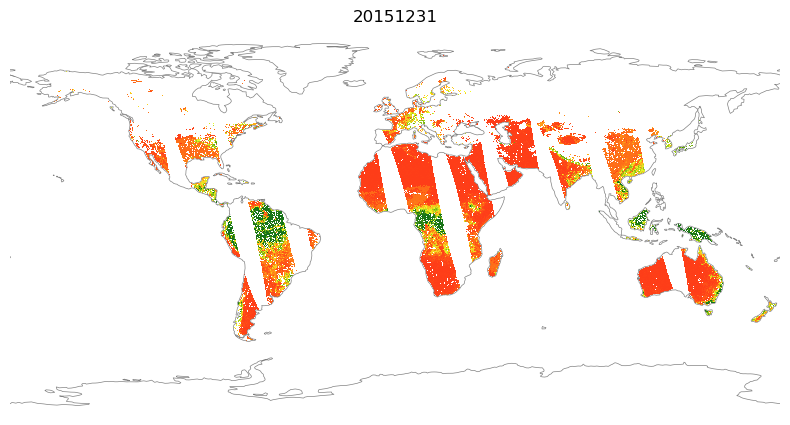

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import imageio
from tqdm import tqdm
import shutil
import gc

# ==========================================================
# 配置参数
# ==========================================================
VWC_DIR = r"G:\data\VWC\VWCMap\CTVWC\Daily"
OUTPUT_GIF = r"G:\data\VWC\VWCMap\CTVWC\VWC_dynamic.gif"
TEMP_FRAME_DIR = r"G:\data\VWC\VWCMap\CTVWC\_frames_temp"
os.makedirs(TEMP_FRAME_DIR, exist_ok=True)

BAND = 1
NODATA_VALUE = -9999
VMIN, VMAX = 0, 20
FPS = 3  # 每秒帧数
FRAME_STEP = 1  # 每3天取一帧

# ==========================================================
# 自定义颜色映射
# ==========================================================
def create_custom_cmap():
    colors = [
        '#fe3c19',  # 0
        '#ffac18',  # 5
        '#f2fe2a',  # 10
        '#7cb815',  # 15
        '#147218'   # 20
    ]
    return LinearSegmentedColormap.from_list('custom_vwc', colors, N=256)

# ==========================================================
# 读取 TIFF 并返回数据与范围
# ==========================================================
def read_vwc_tif(file_path):
    ds = gdal.Open(file_path)
    if ds is None:
        raise FileNotFoundError(file_path)
    band = ds.GetRasterBand(BAND)
    data = band.ReadAsArray().astype(np.float32)
    data[data == NODATA_VALUE] = np.nan
    gt = ds.GetGeoTransform()
    lon_min, lat_max = gt[0], gt[3]
    lon_max = lon_min + gt[1] * ds.RasterXSize
    lat_min = lat_max + gt[5] * ds.RasterYSize
    extent = (lon_min, lon_max, lat_min, lat_max)
    ds = None
    return data, extent

# ==========================================================
# 主程序
# ==========================================================
def main():
    all_files = sorted(glob.glob(os.path.join(VWC_DIR, "VWC-*.tif")))

    # 过滤 2015–2020 年文件
    files = []
    for f in all_files:
        basename = os.path.basename(f)
        try:
            year = int(basename[4:8])  # 提取YYYY
            if 2015 <= year <= 2020:
                files.append(f)
        except ValueError:
            continue

    if not files:
        print("❌ 未找到 2015–2020 年的 VWC 文件。")
        return

    # 抽帧，减小总帧数
    files = files[::FRAME_STEP]

    cmap = create_custom_cmap()

    # 使用第一帧extent确保所有帧一致
    first_data, base_extent = read_vwc_tif(files[0])

    print(f"共检测到 {len(files)} 张抽帧后的图像，将绘制为GIF。")

    # 创建一次 fig 和 ax
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5, color='gray')
    im = ax.imshow(first_data, origin='upper', extent=base_extent, transform=ccrs.PlateCarree(),
                   cmap=cmap, vmin=VMIN, vmax=VMAX, interpolation='nearest')
    ax.set_title("", fontsize=12)
    ax.axis('off')

    # 循环绘制每帧
    for idx, file in enumerate(tqdm(files, desc="绘制帧")):
        data, _ = read_vwc_tif(file)
        im.set_data(data)
        date_label = os.path.basename(file).replace("VWC-", "").replace(".tif", "")
        ax.set_title(date_label, fontsize=12)

        frame_path = os.path.join(TEMP_FRAME_DIR, f"frame_{idx:04d}.png")
        fig.savefig(frame_path, dpi=100, bbox_inches='tight', pad_inches=0)

        # 每100帧强制释放内存
        if idx % 100 == 0:
            gc.collect()

    print("✅ 所有帧绘制完成，开始生成GIF...")

    # 读取帧并生成GIF
    frame_paths = sorted(glob.glob(os.path.join(TEMP_FRAME_DIR, "frame_*.png")))
    with imageio.get_writer(OUTPUT_GIF, mode='I', fps=FPS) as writer:
        for frame_path in tqdm(frame_paths, desc="合成GIF"):
            image = imageio.imread(frame_path)
            writer.append_data(image)

    print(f"✅ GIF已保存至: {OUTPUT_GIF}")

    # 删除临时帧文件夹
    shutil.rmtree(TEMP_FRAME_DIR, ignore_errors=True)
    print("🧹 已清理临时帧文件。")

if __name__ == "__main__":
    main()


### 1.2.4 合成月度数据

In [11]:
# 月度数据合成（适配单波段VWC图像）
import os
import numpy as np
from osgeo import gdal, osr
import datetime
import re
import logging
from tqdm import tqdm

# ============================== 配置日志 ==============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('vwc_monthly_composite.log')
    ]
)
logger = logging.getLogger()

# ============================== 配置参数 ==============================
INPUT_DIR = r'G:\data\VWC\VWCMap\CTVWC\Daily'  # 每日VWC数据目录
OUTPUT_DIR = r'G:\data\VWC\VWCMap\CTVWC\Monthly'  # 月度合成输出目录
START_YEAR = 2015
END_YEAR = 2015
NODATA_VALUE = -9999.0
OVERWRITE_EXISTING = True  # 是否覆盖已存在的月度合成文件

# 确保输出目录存在
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================== 辅助函数 ==============================
def get_daily_files_for_month(year, month):
    """获取指定年月的所有每日文件（仅TIFF格式）"""
    files = []
    pattern = re.compile(r'VWC-(\d{4})(\d{2})(\d{2})\.tif$')  # 匹配YYYYMMDD格式的文件名
    
    for filename in os.listdir(INPUT_DIR):
        if not filename.endswith('.tif'):
            continue
            
        match = pattern.match(filename)
        if not match:
            continue
            
        file_year = int(match.group(1))
        file_month = int(match.group(2))
        file_day = int(match.group(3))
        
        if file_year == year and file_month == month:
            file_path = os.path.join(INPUT_DIR, filename)
            files.append({
                'path': file_path,
                'date': datetime.date(file_year, file_month, file_day)
            })
    
    # 按日期排序
    files.sort(key=lambda x: x['date'])
    return files

def create_monthly_geotiff(data, output_path, year, month, nodata=NODATA_VALUE):
    """创建地理参考的月度TIFF文件（单波段）"""
    try:
        driver = gdal.GetDriverByName('GTiff')
        rows, cols = data.shape
        
        # 创建数据集
        out_ds = driver.Create(
            output_path, 
            cols, 
            rows, 
            1,  # 单波段
            gdal.GDT_Float32,
            options=['COMPRESS=LZW', 'TILED=YES']
        )
        
        # 设置地理变换
        out_ds.SetGeoTransform((-180, 0.1, 0, 90, 0, -0.1))
        
        # 设置坐标系 (WGS84)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        out_ds.SetProjection(srs.ExportToWkt())
        
        # 添加日期元数据
        out_ds.SetMetadata({
            'YEAR': str(year),
            'MONTH': str(month),
            'PRODUCTION_DATE': datetime.date.today().isoformat()
        })
        
        # 写入波段数据
        band = out_ds.GetRasterBand(1)
        band.WriteArray(data)
        band.SetNoDataValue(nodata)
        band.SetDescription('VWC')
        
        # 清理
        out_ds.FlushCache()
        out_ds = None
        logger.info(f"成功创建月度合成GeoTIFF: {output_path}")
        return True
    except Exception as e:
        logger.error(f"创建GeoTIFF失败: {str(e)}")
        return False

def generate_monthly_composites():
    """生成月度合成数据"""
    total_months = (END_YEAR - START_YEAR + 1) * 12
    processed = 0
    
    # 进度条初始化
    pbar = tqdm(total=total_months, desc="月度合成进度")
    
    for year in range(START_YEAR, END_YEAR + 1):
        for month in range(1, 13):
            # 输出文件名 - 格式：VWC-YYYYMM.tif
            output_filename = f'VWC-{year}{str(month).zfill(2)}.tif'
            output_path = os.path.join(OUTPUT_DIR, output_filename)
            
            # 检查文件是否已存在
            if os.path.exists(output_path):
                if OVERWRITE_EXISTING:
                    try:
                        os.remove(output_path)
                        logger.info(f"已删除现有文件: {output_path}")
                    except Exception as e:
                        logger.error(f"删除文件失败: {output_path} - {str(e)}")
                        pbar.update(1)
                        processed += 1
                        continue
                else:
                    logger.info(f"月度合成已存在: {output_path} - 跳过")
                    pbar.update(1)
                    processed += 1
                    continue
            
            # 获取该月的所有每日文件
            files = get_daily_files_for_month(year, month)
            
            if not files:
                logger.warning(f"在{year}年{month}月未找到任何每日文件")
                pbar.update(1)
                processed += 1
                continue
            
            logger.info(f"生成{year}年{month}月合成 ({len(files)}个每日文件)")
            
            # 初始化数据数组
            monthly_sum = None
            valid_count = None
            rows, cols = 0, 0
            
            # 用于存储每日数据的列表（用于中值计算）
            daily_arrays = []
            
            # 处理每个文件
            for file_info in files:
                try:
                    # 打开文件
                    ds = gdal.Open(file_info['path'])
                    if ds is None:
                        logger.warning(f"无法打开文件: {file_info['path']}")
                        continue
                    
                    # 获取图像尺寸（只在第一次确定）
                    if rows == 0:
                        rows = ds.RasterYSize
                        cols = ds.RasterXSize
                        monthly_sum = np.zeros((rows, cols), dtype=np.float32)
                        valid_count = np.zeros((rows, cols), dtype=np.uint16)
                    
                    # 读取唯一波段
                    band = ds.GetRasterBand(1)
                    data = band.ReadAsArray()
                    nodata = band.GetNoDataValue()
                    
                    if nodata is None:
                        nodata = NODATA_VALUE
                    
                    # 创建有效值掩膜
                    valid_mask = (data != nodata) & (~np.isnan(data))
                    
                    # 累加有效值
                    monthly_sum += np.where(valid_mask, data, 0)
                    valid_count += valid_mask.astype(np.uint16)
                    
                    # 收集每日数据用于中值计算
                    daily_arrays.append(data)
                    
                    # 关闭数据集
                    ds = None
                    
                except Exception as e:
                    logger.error(f"处理文件 {file_info['path']} 错误: {str(e)}")
            
            # 计算月度平均值 (避免除以零)
            if monthly_sum is not None and valid_count is not None:
                # 计算平均值
                with np.errstate(divide='ignore', invalid='ignore'):
                    monthly_avg = np.where(
                        valid_count > 0,
                        monthly_sum / valid_count,
                        NODATA_VALUE  # 无效值
                    )
                
                # 计算中值（更健壮的指标）
                if daily_arrays:
                    # 创建数据堆栈
                    stack = np.stack(daily_arrays, axis=0)
                    
                    # 创建有效值掩膜
                    valid_mask = (stack != NODATA_VALUE) & (~np.isnan(stack))
                    
                    # 计算中值
                    monthly_median = np.full((rows, cols), NODATA_VALUE, dtype=np.float32)
                    for i in range(rows):
                        for j in range(cols):
                            # 获取该像素的所有有效值
                            pixel_values = stack[:, i, j][valid_mask[:, i, j]]
                            if len(pixel_values) > 0:
                                monthly_median[i, j] = np.median(pixel_values)
                
                # 保存合成结果 - 使用中值作为更健壮的指标
                success = create_monthly_geotiff(monthly_median, output_path, year, month)
                
                if success:
                    # 输出质量报告
                    valid_percent = (valid_count > 0).sum() / (rows * cols) * 100
                    logger.info(f"月度合成完成: {year}年{month}月, 有效数据: {valid_percent:.2f}%")
                else:
                    logger.error(f"保存月度合成失败: {output_path}")
            
            # 更新进度条
            pbar.update(1)
            processed += 1
    
    # 关闭进度条
    pbar.close()
    logger.info(f"月度合成处理完成! 共处理 {processed} 个月份")

# ============================== 执行主函数 ==============================
if __name__ == "__main__":
    logger.info(f"输入目录: {INPUT_DIR}")
    logger.info(f"输出目录: {OUTPUT_DIR}")
    logger.info(f"生成月度合成数据: {START_YEAR} 到 {END_YEAR}")
    logger.info(f"覆盖模式: {'开启' if OVERWRITE_EXISTING else '关闭'}")
    
    try:
        generate_monthly_composites()
        logger.info("月度合成数据生成完成")
    except Exception as e:
        logger.error(f"处理过程中发生错误: {str(e)}", exc_info=True)

2025-11-28 13:02:56,830 - INFO - 输入目录: G:\data\VWC\VWCMap\CTVWC\Daily


2025-11-28 13:02:56,840 - INFO - 输出目录: G:\data\VWC\VWCMap\CTVWC\Monthly
2025-11-28 13:02:56,841 - INFO - 生成月度合成数据: 2015 到 2015
2025-11-28 13:02:56,841 - INFO - 覆盖模式: 开启
月度合成进度:   0%|          | 0/12 [00:00<?, ?it/s]2025-11-28 13:02:56,846 - INFO - 生成2015年1月合成 (31个每日文件)
2025-11-28 13:03:24,913 - INFO - 成功创建月度合成GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Monthly\VWC-201501.tif
2025-11-28 13:03:24,921 - INFO - 月度合成完成: 2015年1月, 有效数据: 13.71%
月度合成进度:   8%|▊         | 1/12 [00:28<05:08, 28.08s/it]2025-11-28 13:03:24,923 - INFO - 生成2015年2月合成 (28个每日文件)
2025-11-28 13:03:53,097 - INFO - 成功创建月度合成GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Monthly\VWC-201502.tif
2025-11-28 13:03:53,104 - INFO - 月度合成完成: 2015年2月, 有效数据: 14.23%
月度合成进度:  17%|█▋        | 2/12 [00:56<04:41, 28.14s/it]2025-11-28 13:03:53,106 - INFO - 生成2015年3月合成 (31个每日文件)
2025-11-28 13:04:25,826 - INFO - 成功创建月度合成GeoTIFF: G:\data\VWC\VWCMap\CTVWC\Monthly\VWC-201503.tif
2025-11-28 13:04:25,833 - INFO - 月度合成完成: 2015年3月, 有效数据: 17.02%
月度合成进度:  25%|██▌       | 3/12

### 1.2.5 月度数据绘图（Project312）

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl

# ==========================================================
# 配置参数
# ==========================================================
VWC_DIR = r"G:\data\VWC\VWCMap\CTVWC\Monthly"
YEAR = 2015
BAND = 1
OUTPUT_DIR = r"G:\data\VWC\VWCMap\CTVWC"
OUTPUT_NAME = "Global_VWC_Monthly_2015"

MAIN_TYPE_FILE = r'G:\data\ESACCI PFT\Resample\Data\mainType.tif'
MASK_TYPES = [0, 1, 2]
NODATA_VALUE = -9999.0

# ==========================================================
# 掩膜处理函数
# ==========================================================
def load_main_type_mask():
    ds = gdal.Open(MAIN_TYPE_FILE, gdal.GA_ReadOnly)
    if ds is None:
        raise FileNotFoundError(f"无法打开主地物类型文件: {MAIN_TYPE_FILE}")

    band = ds.GetRasterBand(1)
    main_type = band.ReadAsArray()
    mask = np.isin(main_type, MASK_TYPES)

    nodata = band.GetNoDataValue()
    if nodata is not None:
        mask = np.logical_and(mask, main_type != nodata)

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    ds = None

    print("成功加载主地物类型掩膜")
    return mask, geotransform, projection


def apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection):
    ds = gdal.Open(file_path, gdal.GA_Update)
    if ds is None:
        raise FileNotFoundError(f"无法打开VWC文件: {file_path}")

    if (ds.GetGeoTransform() != ref_geotransform or
            ds.GetProjection() != ref_projection):
        raise ValueError("空间参考不匹配，请确保文件投影一致")

    band = ds.GetRasterBand(BAND)
    data = band.ReadAsArray()
    data[mask] = NODATA_VALUE
    band.WriteArray(data)
    band.SetNoDataValue(NODATA_VALUE)

    ds.FlushCache()
    ds = None
    print(f"成功掩膜处理: {os.path.basename(file_path)}")


# ==========================================================
# 数据读取函数
# ==========================================================
def read_vwc_tif(file_path, band=1, no_data=-9999):
    ds = gdal.Open(file_path)
    band = ds.GetRasterBand(band)
    data = band.ReadAsArray()

    geotransform = ds.GetGeoTransform()
    xsize, ysize = ds.RasterXSize, ds.RasterYSize
    lon_min, lat_max = geotransform[0], geotransform[3]
    lon_max = lon_min + geotransform[1] * xsize
    lat_min = lat_max + geotransform[5] * ysize

    data = data.astype(np.float32)
    data[data == no_data] = np.nan
    ds = None
    return data, (lon_min, lon_max, lat_min, lat_max)


# ==========================================================
# 颜色映射
# ==========================================================
def create_custom_cmap():
    colors = ['#fe3c19', '#ffac18', '#f2fe2a', '#7cb815', '#147218']
    return LinearSegmentedColormap.from_list('custom_vwc', colors, N=256)


# ==========================================================
# 绘图函数
# ==========================================================
def plot_vwc_map(ax, data, extent, title):
    cmap = create_custom_cmap()
    ax.set_global()
    ax.coastlines(linewidth=0.5, color='gray')

    gl = ax.gridlines(draw_labels=False, linestyle='--', alpha=0.6)
    ax.imshow(data, origin='upper', extent=extent,
              transform=ccrs.PlateCarree(),
              cmap=cmap, vmin=0, vmax=20)
    ax.set_title(title, fontsize=16)


# ==========================================================
# 主程序
# ==========================================================
def main():
    print("======== 开始掩膜处理 ========")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    mask, ref_geo, ref_proj = load_main_type_mask()

    months = [f"{YEAR}{i:02d}" for i in range(1, 13)]
    vwc_data = []

    for m_code in months:
        fpath = os.path.join(VWC_DIR, f"VWC-{m_code}.tif")
        if not os.path.exists(fpath):
            print(f"跳过：文件不存在 - {fpath}")
            continue

        # 注意：此处您正在修改原始文件，请确保这是预期行为。
        apply_mask_to_vwc_file(fpath, mask, ref_geo, ref_proj)
        data, extent = read_vwc_tif(fpath, band=BAND, no_data=NODATA_VALUE)
        vwc_data.append({"data": data, "extent": extent, "label": m_code})

    print("======== 掩膜处理完成 ========")

# 绘图
    fig = plt.figure(figsize=(18, 10))
    
    # -------------------------------------------------------------
    # 核心修改点：使用 height_ratios 缩小最后一行（颜色条行）的高度
    # -------------------------------------------------------------
    # 创建 4x4 的网格
    # 前三行用于地图，最后一行用于颜色条。
    # 我们设置前三行的比例为 1，最后一行的比例为 0.05 (你可以根据需要调整这个小数值)
    gs = gridspec.GridSpec(
        4, 4, 
        figure=fig, 
        wspace=0.15, 
        hspace=0.20,
        height_ratios=[1, 1, 1, 0.05] # <--- 关键修改
    )

    for i, item in enumerate(vwc_data):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection=ccrs.PlateCarree())
        plot_vwc_map(ax, item["data"], item["extent"], item["label"])

    # 颜色条底部单行
    # 使用修改后的 GridSpec 行高，并沿用缩小水平宽度的逻辑
    cax = fig.add_subplot(gs[3, 1:3]) # 占据最后一行，且只占据中间两列
    norm = mpl.colors.Normalize(vmin=0, vmax=20)
    cmap = create_custom_cmap()
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax, 
                        orientation='horizontal', 
                        ticks=[0, 5, 10, 15, 20])
                        
    cbar.set_label('VWC (kg/m²)', fontsize=18)

    # -------------------------------------------------------------

    output_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_NAME}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"绘图完成，结果已保存：{output_path}")


if __name__ == "__main__":
    main()


======== 开始掩膜处理 ========
成功加载主地物类型掩膜


c:\Users\Ronin\.conda\envs\Project312\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


成功掩膜处理: VWC-201501.tif
成功掩膜处理: VWC-201502.tif
成功掩膜处理: VWC-201503.tif
成功掩膜处理: VWC-201504.tif
成功掩膜处理: VWC-201505.tif
成功掩膜处理: VWC-201506.tif
成功掩膜处理: VWC-201507.tif
成功掩膜处理: VWC-201508.tif
成功掩膜处理: VWC-201509.tif
成功掩膜处理: VWC-201510.tif
成功掩膜处理: VWC-201511.tif
成功掩膜处理: VWC-201512.tif
======== 掩膜处理完成 ========
绘图完成，结果已保存：G:\data\VWC\VWCMap\CTVWC\Global_VWC_Monthly_2015.png


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl

# ==========================================================
# 配置参数
# ==========================================================
VWC_DIR = r"G:\data\VWC\VWCMap\CTVWC\Monthly"
SPECIFIC_MONTHS = {
    "2015-01": "201501",
    "2015-04": "201504",
    "2015-07": "201507",
    "2015-10": "201510"
}
BAND = 1  # 读取第一个波段
OUTPUT_DIR = r"G:\data\VWC\VWCMap\CTVWC"
OUTPUT_NAME = "Global_VWC_Seasonal_2015_6VOD_LAI_PFTs_Hveg"

# 掩膜相关参数
MAIN_TYPE_FILE = r'G:\data\ESACCI PFT\Resample\Data\mainType.tif'
MASK_TYPES = [0, 1, 2]  # 0=water, 1=bare, 2=snowice
NODATA_VALUE = -9999.0


# ==========================================================
# 掩膜处理函数
# ==========================================================
def load_main_type_mask():
    """加载主地物类型掩膜"""
    ds = gdal.Open(MAIN_TYPE_FILE, gdal.GA_ReadOnly)
    if ds is None:
        raise FileNotFoundError(f"无法打开主地物类型文件: {MAIN_TYPE_FILE}")

    band = ds.GetRasterBand(1)
    main_type = band.ReadAsArray()
    mask = np.isin(main_type, MASK_TYPES)

    nodata = band.GetNoDataValue()
    if nodata is not None:
        mask = np.logical_and(mask, main_type != nodata)

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    ds = None

    print("成功加载主地物类型掩膜")
    return mask, geotransform, projection


def apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection):
    """对单个VWC文件应用掩膜"""
    ds = gdal.Open(file_path, gdal.GA_Update)
    if ds is None:
        raise FileNotFoundError(f"无法打开VWC文件: {file_path}")

    if (ds.GetGeoTransform() != ref_geotransform or
        ds.GetProjection() != ref_projection):
        raise ValueError("空间参考不匹配，请确保文件投影一致")

    band = ds.GetRasterBand(BAND)
    data = band.ReadAsArray()
    data[mask] = NODATA_VALUE
    band.WriteArray(data)
    band.SetNoDataValue(NODATA_VALUE)

    ds.FlushCache()
    ds = None
    print(f"成功掩膜处理: {os.path.basename(file_path)}")


# ==========================================================
# 数据读取函数
# ==========================================================
def read_vwc_tif(file_path, band=1, no_data=-9999):
    """读取VWC TIFF文件"""
    ds = gdal.Open(file_path)
    if ds is None:
        raise FileNotFoundError(f"无法打开文件: {file_path}")

    band = ds.GetRasterBand(band)
    data = band.ReadAsArray()

    geotransform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    x_size = ds.RasterXSize
    y_size = ds.RasterYSize
    lon_min = geotransform[0]
    lat_max = geotransform[3]
    lon_max = lon_min + geotransform[1] * x_size
    lat_min = lat_max + geotransform[5] * y_size

    data = data.astype(np.float32)
    data[data == no_data] = np.nan

    ds = None
    return data, (lon_min, lon_max, lat_min, lat_max), projection


# ==========================================================
# 自定义颜色映射
# ==========================================================
def create_custom_cmap():
    colors = [
        '#fe3c19',  # 0
        '#ffac18',  # 5
        '#f2fe2a',  # 10
        '#7cb815',  # 15
        '#147218'   # 20
    ]
    return LinearSegmentedColormap.from_list('custom_vwc', colors, N=256)


# ==========================================================
# 绘制地图
# ==========================================================
def plot_vwc_map(ax, data, extent, month_label, vmin=0, vmax=20):
    cmap = create_custom_cmap()
    ax.coastlines(linewidth=0.5, color='gray')
    ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m',
                                       facecolor='lightblue', alpha=0.3))
    ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '50m',
                                       edgecolor='gray', facecolor='none', linewidth=0.3))

    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.xlabel_style = {'fontsize': 16}
    gl.ylabel_style = {'fontsize': 16}
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    im = ax.imshow(data, origin='upper', extent=extent,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap, vmin=vmin, vmax=vmax,
                   interpolation='nearest')
    ax.set_title(f"{month_label}", fontsize=24, pad=10)
    return im


# ==========================================================
# 主程序
# ==========================================================
def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print("======== 开始掩膜处理 ========")

    mask, ref_geotransform, ref_projection = load_main_type_mask()

    for label, month_code in SPECIFIC_MONTHS.items():
        file_path = os.path.join(VWC_DIR, f"VWC-{month_code}.tif")
        if os.path.exists(file_path):
            apply_mask_to_vwc_file(file_path, mask, ref_geotransform, ref_projection)
        else:
            print(f"警告: 文件不存在 - {file_path}")

    print("======== 掩膜处理完成 ========")

    vwc_data = []
    for label, month_code in SPECIFIC_MONTHS.items():
        file_path = os.path.join(VWC_DIR, f"VWC-{month_code}.tif")
        if not os.path.exists(file_path):
            continue
        data, extent, projection = read_vwc_tif(file_path, band=BAND, no_data=NODATA_VALUE)
        vwc_data.append({"data": data, "extent": extent, "label": label})

    if not vwc_data:
        print("错误: 无有效数据，无法绘制")
        return

    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(3, 2, figure=fig,
                           wspace=0.20, hspace=0.04,
                           top=0.95, bottom=0.1,
                           left=0.05, right=0.95,
                           height_ratios=[1, 1, 0.05])

    axs = [
        fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
    ]

    for i in range(4):
        if i < len(vwc_data):
            ax = axs[i]
            data = vwc_data[i]['data']
            extent = vwc_data[i]['extent']
            label = vwc_data[i]['label']
            ax.set_global()
            plot_vwc_map(ax, data, extent, label)

    # 颜色条跨两列
    cax = fig.add_subplot(gs[2, :])
    norm = mpl.colors.Normalize(vmin=0, vmax=20)
    cmap = create_custom_cmap()
    ticks = [0, 5, 10, 15, 20]
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax, orientation='horizontal', ticks=ticks)
    cbar.set_label('VWC (kg/m²)', fontsize=24)
    cbar.ax.tick_params(labelsize=16)

    plt.suptitle("", fontsize=24, y=0.98)

    output_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_NAME}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"结果已保存至: {output_path}")
    plt.close()


if __name__ == "__main__":
    main()


======== 开始掩膜处理 ========
成功加载主地物类型掩膜
成功掩膜处理: VWC-201501.tif
成功掩膜处理: VWC-201504.tif
成功掩膜处理: VWC-201507.tif
成功掩膜处理: VWC-201510.tif
======== 掩膜处理完成 ========
结果已保存至: G:\data\VWC\VWCMap\CTVWC\Global_VWC_Seasonal_2015_6VOD_LAI_PFTs_Hveg.png


## 1.2.6 精度验证部分

### （1）填充CTVWC影像

In [5]:
# 先填充CTVWC的影像，使其满足验证数据
import os
import pandas as pd
import rasterio
from datetime import datetime

# 配置路径
excel_path = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
tif_folder = r"G:\data\VWC\VWCMap\CTVWC\Daily"

# 读取Excel文件
with pd.ExcelFile(excel_path) as xls:
    sheet_names = xls.sheet_names
    sheets_dict = {sheet: pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names}

# 处理每个sheet
for sheet_name, df in sheets_dict.items():
    # 添加新列
    df['CTVWC RF products'] = None
    
    # 检查是否存在日期列
    if 'Date' not in df.columns and 'Datetime' not in df.columns:
        print(f"Sheet '{sheet_name}' 缺少日期列，跳过处理")
        continue
    
    # 确定日期列名
    date_col = 'Date' if 'Date' in df.columns else 'Datetime'
    
    # 转换日期为字符串格式YYYYMMDD
    df['date_str'] = df[date_col].apply(
        lambda x: x.strftime('%Y%m%d') if isinstance(x, datetime) else str(x).split()[0].replace('-', '')
    )
    
    # 分组处理相同日期的数据
    grouped = df.groupby('date_str')
    
    for date_str, group in grouped:
        tif_path = os.path.join(tif_folder, f"VWC-{date_str}.tif")
        
        # 检查TIFF文件是否存在
        if not os.path.exists(tif_path):
            print(f"文件不存在: {tif_path}")
            continue
        
        try:
            # 读取TIFF文件
            with rasterio.open(tif_path) as src:
                # 检查TIFF尺寸
                if src.height != 1800 or src.width != 3600:
                    print(f"警告: {tif_path} 尺寸不符 ({src.height}x{src.width})")
                
                # 提取数据
                for idx, row in group.iterrows():
                    try:
                        # 转换为整数索引（假设行列索引从1开始）
                        row_idx = int(row['row']) - 1
                        col_idx = int(row['col']) - 1
                        
                        # 验证索引范围
                        if 0 <= row_idx < 1800 and 0 <= col_idx < 3600:
                            # 读取像素值
                            value = src.read(1, window=((row_idx, row_idx+1), (col_idx, col_idx+1)))
                            df.at[idx, 'CTVWC RF products'] = value[0, 0]
                    except (ValueError, KeyError) as e:
                        print(f"行列索引错误: {e}")
        except rasterio.RasterioIOError:
            print(f"无法读取文件: {tif_path}")
    
    # 删除临时列
    df.drop('date_str', axis=1, inplace=True)

# 保存更新后的Excel文件
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for sheet_name, df in sheets_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("处理完成！")

处理完成！


### （2）绘制（1）中的散点图

✅ 图像已保存至:
G:\data\VWC\VWCMap\CTVWC\Scatter_American.png


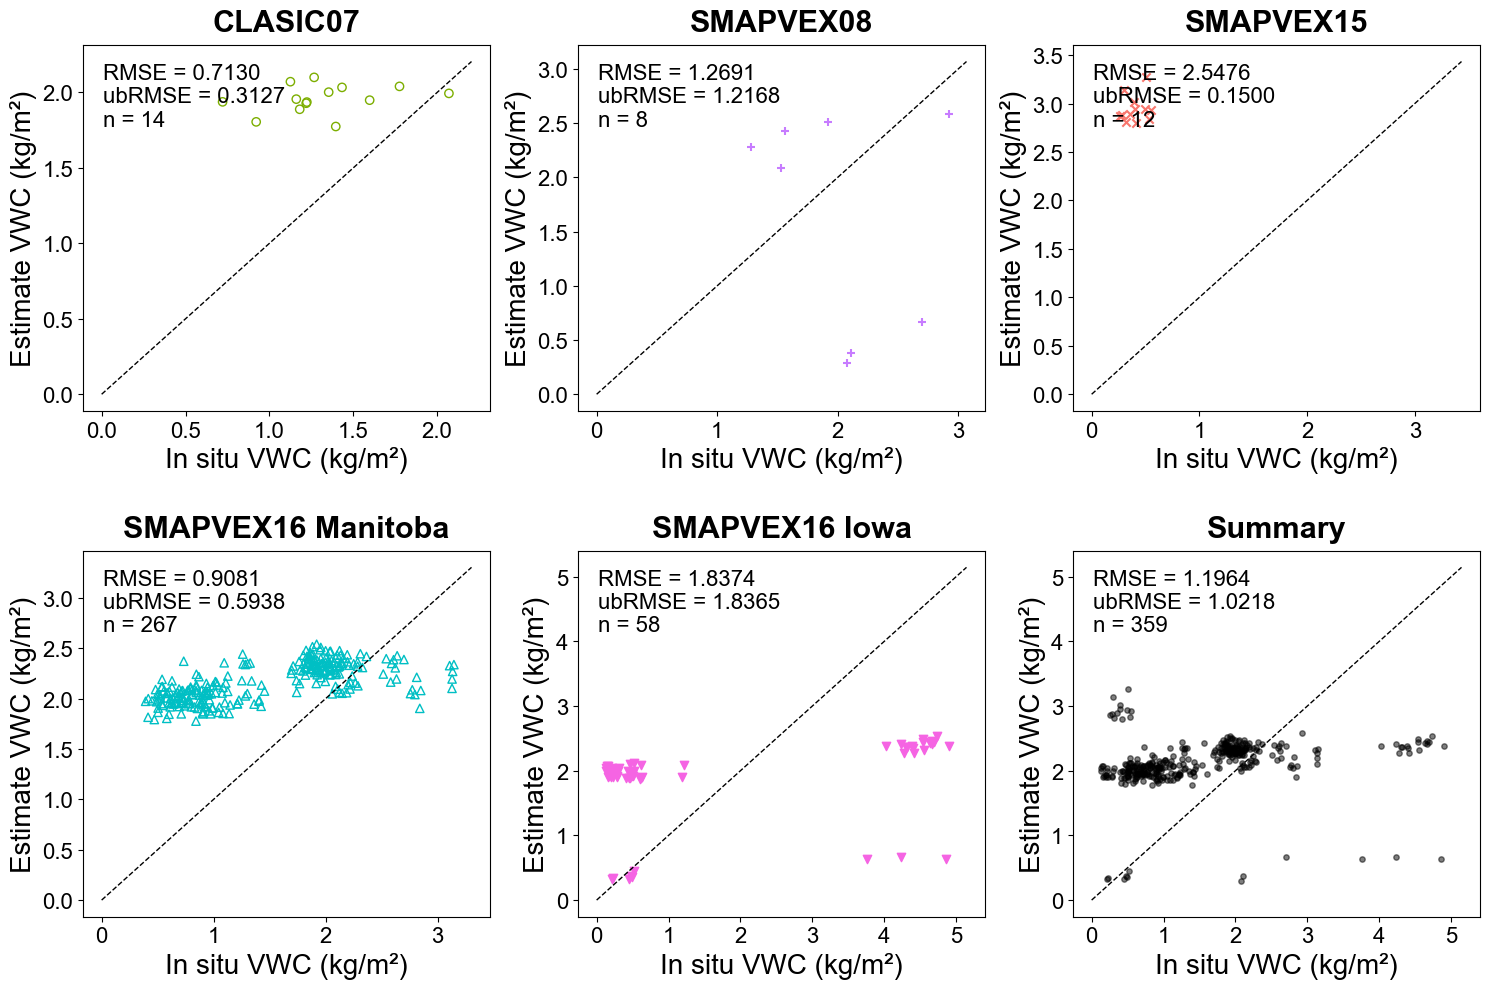

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 输入与输出路径
INPUT_FILE = r"G:\data\VWC\test-VWC\VWC Map Validation\VWC_Map_results_ML.xlsx"
OUTPUT_FILE = r"G:\data\VWC\VWCMap\CTVWC\Scatter_American.png"

# Sheet名称与样式（去掉 SMEX02）
SHEET_MAP = {
    "CLASIC07": {"marker": "o", "facecolor": "none", "edgecolor": "#7CAE00"},
    "SMAPVEX08": {"marker": "+", "color": "#C77CFF"},
    "SMAPVEX15": {"marker": "x", "color": "#F8766D"},
    "SMAPVEX16 Manitoba": {"marker": "^", "facecolor": "none", "edgecolor": "#00BFC4"},
    "SMAPVEX16 Iowa": {"marker": "v", "color": "#F564E3"},
}

# 计算指标函数
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return rmse, ubrmse, r2, n

def main():
    plt.rcParams["font.family"] = "Arial"

    # 调整布局：共 6 个子图（去掉 SMEX02 后，右下角留给 Summary）
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    all_true, all_pred = [], []  # 用于汇总 Summary 数据
    idx = 0

    for sheet, style in SHEET_MAP.items():
        df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
        df["CTVWC RF products"] = df["CTVWC RF products"].replace(-9999, np.nan)
        df = df.dropna(subset=["Map VWC", "CTVWC RF products"])
        df = df.drop_duplicates(subset=["LonC", "LatC", "Map VWC"], keep="first")

        if df.empty:
            print(f"⚠️ 跳过 {sheet}（无有效数据）")
            continue

        y_true = df["Map VWC"].values
        y_pred = df["CTVWC RF products"].values

        # 汇总保存
        all_true.extend(y_true)
        all_pred.extend(y_pred)

        rmse, ubrmse, r2, n = calc_metrics(y_true, y_pred)
        ax = axes[idx]
        idx += 1

        ax.scatter(y_true, y_pred, **style)

        max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
        ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        ax.tick_params(axis='both', labelsize=16)
        ax.set_title(sheet, fontsize=22, fontweight="bold", pad=10)

        ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )

    # 绘制 Summary 子图
    summary_ax = axes[-1]
    if all_true and all_pred:
        all_true = np.array(all_true)
        all_pred = np.array(all_pred)
        rmse, ubrmse, r2, n = calc_metrics(all_true, all_pred)

        summary_ax.scatter(
            all_true, all_pred, s=15, color="black", alpha=0.5, label="All points"
        )
        max_val = max(np.max(all_true), np.max(all_pred)) * 1.05
        summary_ax.plot([0, max_val], [0, max_val], "k--", lw=1)
        summary_ax.set_xlabel("In situ VWC (kg/m²)", fontsize=20)
        summary_ax.set_ylabel("Estimate VWC (kg/m²)", fontsize=20)
        summary_ax.tick_params(axis='both', labelsize=16)
        summary_ax.set_title("Summary", fontsize=22, fontweight="bold", pad=10)
        summary_ax.text(
            0.05,
            0.95,
            f"RMSE = {rmse:.4f}\n"
            f"ubRMSE = {ubrmse:.4f}\n"
            f"n = {n}",
            transform=summary_ax.transAxes,
            fontsize=16,
            verticalalignment="top",
        )
    else:
        summary_ax.axis("off")
        summary_ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=20)

    plt.tight_layout(h_pad=3.0)
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"✅ 图像已保存至:\n{OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()
